# Exploration of confidence or certainty the predictions

In [15]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


#### Init.

In [ ]:
K = 1000

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   positive_class = [1],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='multimodal_paper_final', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=None, random_state=random_state)
    display(exp.performances_df)
    
    

In [9]:
from sklearn.metrics import  (confusion_matrix, roc_curve, fbeta_score)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg
from utils import compute_SD
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve

def compute_results(y_true, y_pred, threshold, name='?', title=""):


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))
    
    # Compute f1 and f2 scores
    f1 = fbeta_score(y_true, y_pred > threshold, beta=1) 
    f2 = fbeta_score(y_true, y_pred >= threshold, beta=2) 

    # Compute the F1 score
    #f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    #f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)
    
    # Compute corrected F1 and F2
    f1_c = 2*(ppv_corr*tpr)/(ppv_corr+tpr)
    
    beta = 2
    f2_c = (1+beta**2)*(ppv_corr*tpr)/(beta**2 * ppv_corr + tpr)

    performances_dict = {'name':name+'\n(N='+str(len(y_true))+')', 
                         'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_c, 3),
                        'F2': round(f2, 3),
                        'F2 Corrected': round(f2_c, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Corrected Precision or positive predictive value (PPV)': round(ppv_corr, 3),
                        'Corrected NPV': round(npv_corr, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3),
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn
                        }
    
    performances_df = pd.DataFrame(performances_dict, index=[name+'\n(N='+str(len(y_true))+')'])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    performances_df['y_true'] = [y_true]
    performances_df['y_pred'] = [y_pred]
    performances_df['Hanley_CI'] = performances_df['AUROC'] .apply(lambda x: compute_SD(x, np.sum(y_true==0), np.sum(y_true==1)))

    
    
    
    if False:
        display(performances_df)

        fig_mosaic = """
                        AB
                    """

        fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

        fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

        cm = confusion_matrix(y_true, y_pred >= threshold)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

        # Plot the roc curves

        fpr, tpr, _ = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        axes['A'].plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
        axes['A'].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes['A'].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes['A'].grid()
        axes['A'].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
    return performances_df

In [10]:
from utils import find_optimal_threshold_f

y_pred = performances_df.iloc[0]['y_pred']
y_true = performances_df.iloc[0]['y_true']

best_f1, best_f2, f1_c, f2_c, index_optimal_f1, index_optimal_f2, threshold_optimal_f2 = find_optimal_threshold_f(y_true, y_pred)


In [11]:
best_f1, best_f2, f1_c, f2_c, index_optimal_f1, index_optimal_f2, threshold_optimal_f2

(0.7119205298013245,
 0.7119205298013245,
 0.16072709039364777,
 0.31521761554701305,
 9,
 33,
 0.382)

In [12]:
compute_results(y_true, y_pred, threshold_optimal_f2)

name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Corrected NPV  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN  TN_normalized  TP_normalized  FP_normalized  FN_normalized    N                                             y_true                                             y_pred  Hanley_CI
?\n(N=377)  ?\n(N=377)  0.899   0.622        0.935             0.222                  0.953                           0.549               0.157  0.698         0.308     0.814                                   0.499                                              0.857                                                       0.808                                              0.4                                              0.087               0.996                            0.974                                   0.143                               0.6                            0.026  42  265  63   7      70.291777      11.140584      16.710875       1.856764  377  [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...  [0.001, 1.0, 0.001, 0.775, 0.27, 0.283, 0.177,...   0.017421

In [298]:
#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['25_Janvier_Final_Importance_Computation_with_pwb'])#'13_november_bis'])#'November 2022'])

100%|██████████| 101/101 [00:36<00:00,  2.77it/s]


**Computation of the average Shap values (no normalisation yet)**

In [213]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/25_Janvier_Final_Importance_Computation_with_pwb/SenseToKnow/'

json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_interactions.shape

(100, 377, 23, 23)

**Computation of the feature impotance by summing over the interactions effect**

In [214]:
shap_values = shap_interactions.sum(axis=2)
shap_values.shape

(100, 377, 23)

**Normalization of the Shap values for each individuals so that the Shap values are comparable, given that they come from differet models being trained.**

In [215]:
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]

np.abs(shap_values_n[0, 0]).sum()

1.0

**For a random individual this shows the fluctuations of their Shap values over different training step of the Cross-Validation**

The fluctuations we observe are due to the models differences when training it using different set of training data when the random sample is among the test set. Ideally if the model does not overfit the data and is robust, we should not see significant fluctuations

Subject:192


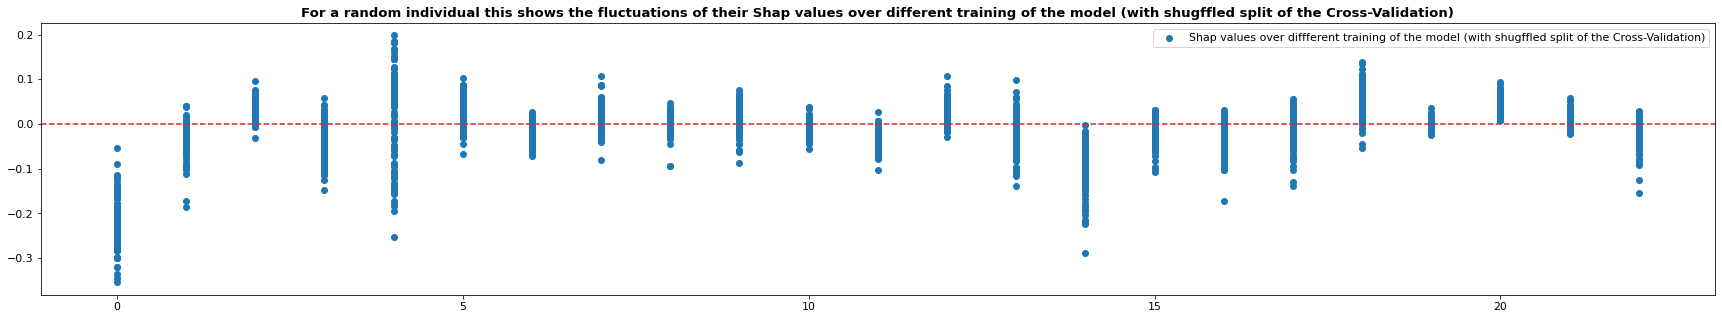

In [216]:
subject_of_interest = np.random.randint(shap_interactions.shape[1])
print("Subject:{}".format(subject_of_interest))

fi(30, 5)
n_model = shap_interactions.shape[0]
plt.title("For a random individual this shows the fluctuations of their Shap values over different training of the model (with shugffled split of the Cross-Validation)", weight='bold')
for i  in range(shap_interactions.shape[2]):
    plt.scatter([i]*n_model, shap_values_n[:, subject_of_interest, i], color='tab:blue', label="Shap values over diffferent training of the model (with shugffled split of the Cross-Validation)" if i==0 else None)
    
plt.axhline(0, linestyle='--', color='tab:red')
_ = plt.legend()


**Now we average the shap values over the K (=50)  training that were performed.**

In [217]:
shap_values_n.shape

(100, 377, 23)

**Averaging the Shap values over the different training**

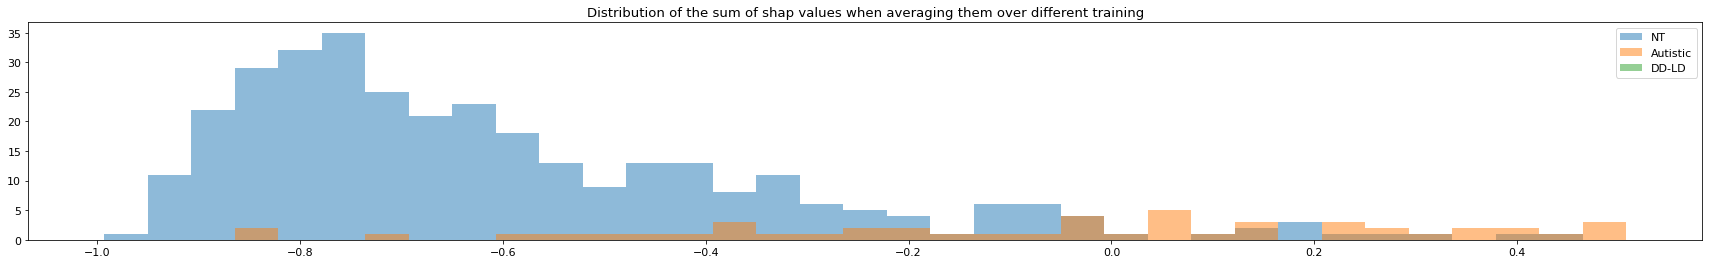

In [219]:
shap_values_averaged = shap_values_n.mean(axis=0)

fi(30, 4)
plt.title("Distribution of the sum of shap values when averaging them over different training")
_, _, _ = plt.hist(shap_values_averaged[i_nt].sum(axis=1), bins=bins, label='NT',alpha=.5, color='tab:blue')
_, _, _ = plt.hist(shap_values_averaged[i_asd].sum(axis=1), bins=bins,  label='Autistic',alpha=.5, color='tab:orange')
_, _, _ = plt.hist(shap_values_averaged[i_ddld].sum(axis=1), bins=bins,  label='DD-LD',alpha=.5, color='tab:green')


_  = plt.legend()

**Note that the Shap values of the samples are no longer normalized because of the averaging over different training, see here the average sum of absolute shap values:**

In [220]:
np.abs(shap_values_averaged).sum(axis=1).mean()

0.9183734713599317

**We therefore renormalize them**

In [221]:
shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]
np.abs(shap_values_averaged_n).sum(axis=1).mean()

1.0

**We now check that the final Shap values for 5 random samples are consistent with what we can observe during a random taining for a sample**

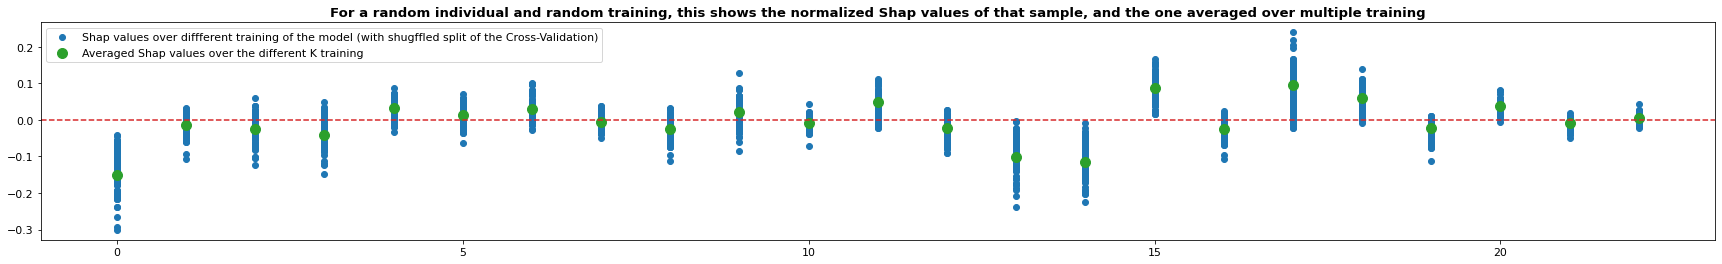

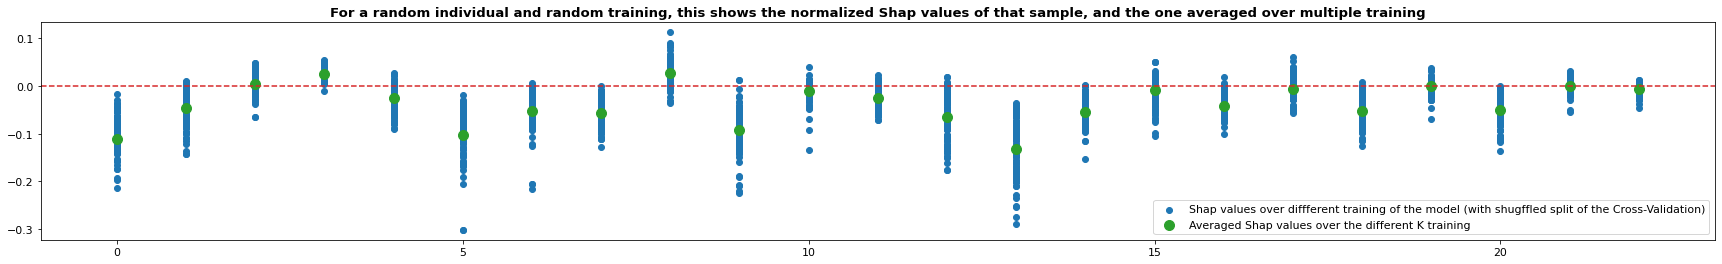

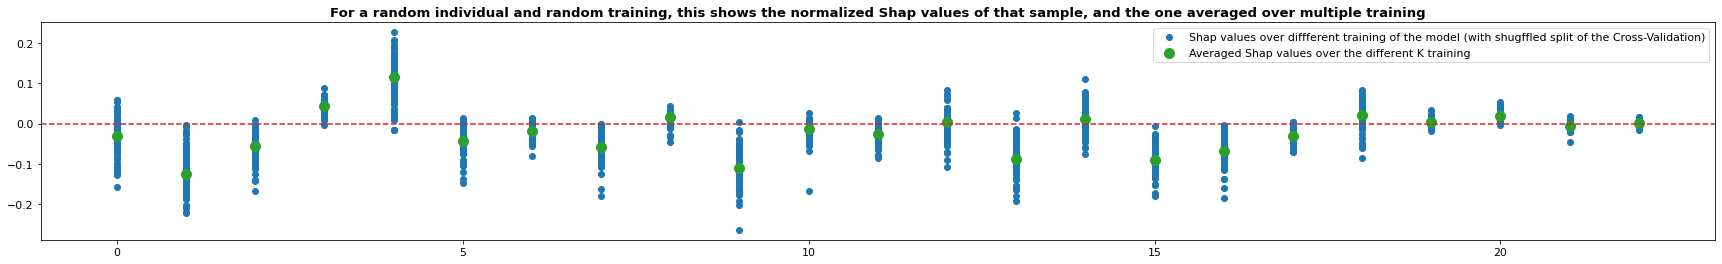

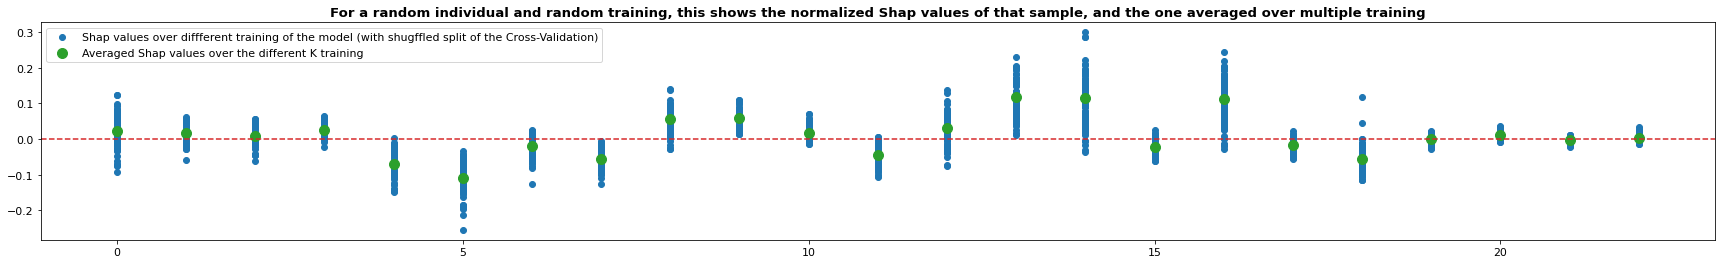

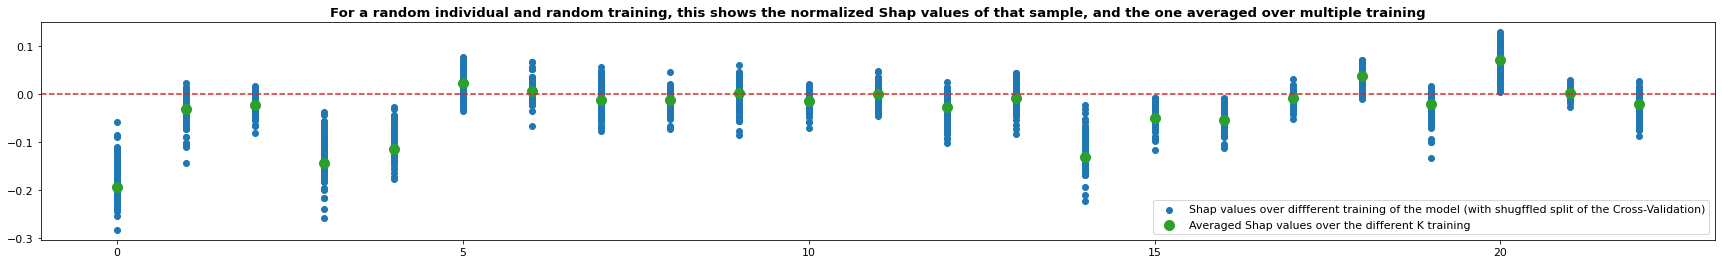

In [222]:
random_samples =  np.random.randint(0, shap_values_n.shape[1], 5)


for random_sample in random_samples:

    n_training = shap_values_n.shape[0]
    fi(30, 4)
    plt.title("For a random individual and random training, this shows the normalized Shap values of that sample, and the one averaged over multiple training", weight='bold')
    for i  in range(shap_values_averaged_n.shape[1]):
        plt.scatter([i]*n_training, shap_values_n[:, random_sample, i], color='tab:blue', label="Shap values over diffferent training of the model (with shugffled split of the Cross-Validation)" if i==0 else None)
        plt.scatter([i], shap_values_averaged_n[random_sample, i], color='tab:green', s=100, label="Averaged Shap values over the different K training" if i==0 else None)
    plt.axhline(0, linestyle='--', color='tab:red')
    plt.legend()
    plt.show()

**At this point, `shap_values_averaged_n` contains the Shap Values of the final sample.** 

- We can compute the compliance score
- We could plot the final Shap values importance but we need to see if sampling will be improving

In [223]:
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'Average_normalized_Shap_values_regular_sample_before_weighting.npy'), shap_values_averaged_n)

# Computation of the shapley values acccounting for features missingness.

For each of the stored Shap values (i.e. the attribution of features importance on each sample), some might be associated to the contribution of the feature being missing, if for that sample the feature were actually missing.
In order to put things in order and disentangled to importance of the features values and their missingness, we here set to 0 the shapley value asociated to missing feature (HYP: the underlying hypothesis of doing that is that if a value is unknown, its contribution should be 0, and rather what should have this contrinution is the missingness of that variable).

*Notes*
- Given that the shap values was collected on each sample using cross-validation, i.e training a different model every time, we cannot compare or average the shap values directly. We first need to normalize each shap values $(\phi_k^i)_{k \in [1, K]}$ for $i \in [1, N]$. Since the sign is informative we still conserve it. 
- We verify that the features themselves have higher importance than their missingness.
- To compute the global importance of each of the features (when there are known, not when we miss them), we proceed as follows:
    1) First we only take into account the first half of the `general_shap_values_normalized` (features attribution when the values are know)

In [224]:
print("{} missing values".format((np.isnan(exp.dataset._X_train)).astype(int).sum()))

851 missing values


In [225]:
shap_values_averaged_n.shape

(377, 23)

In [13]:
ROOT_DIR

'/home01/sam/notes_on_stats/doc/'

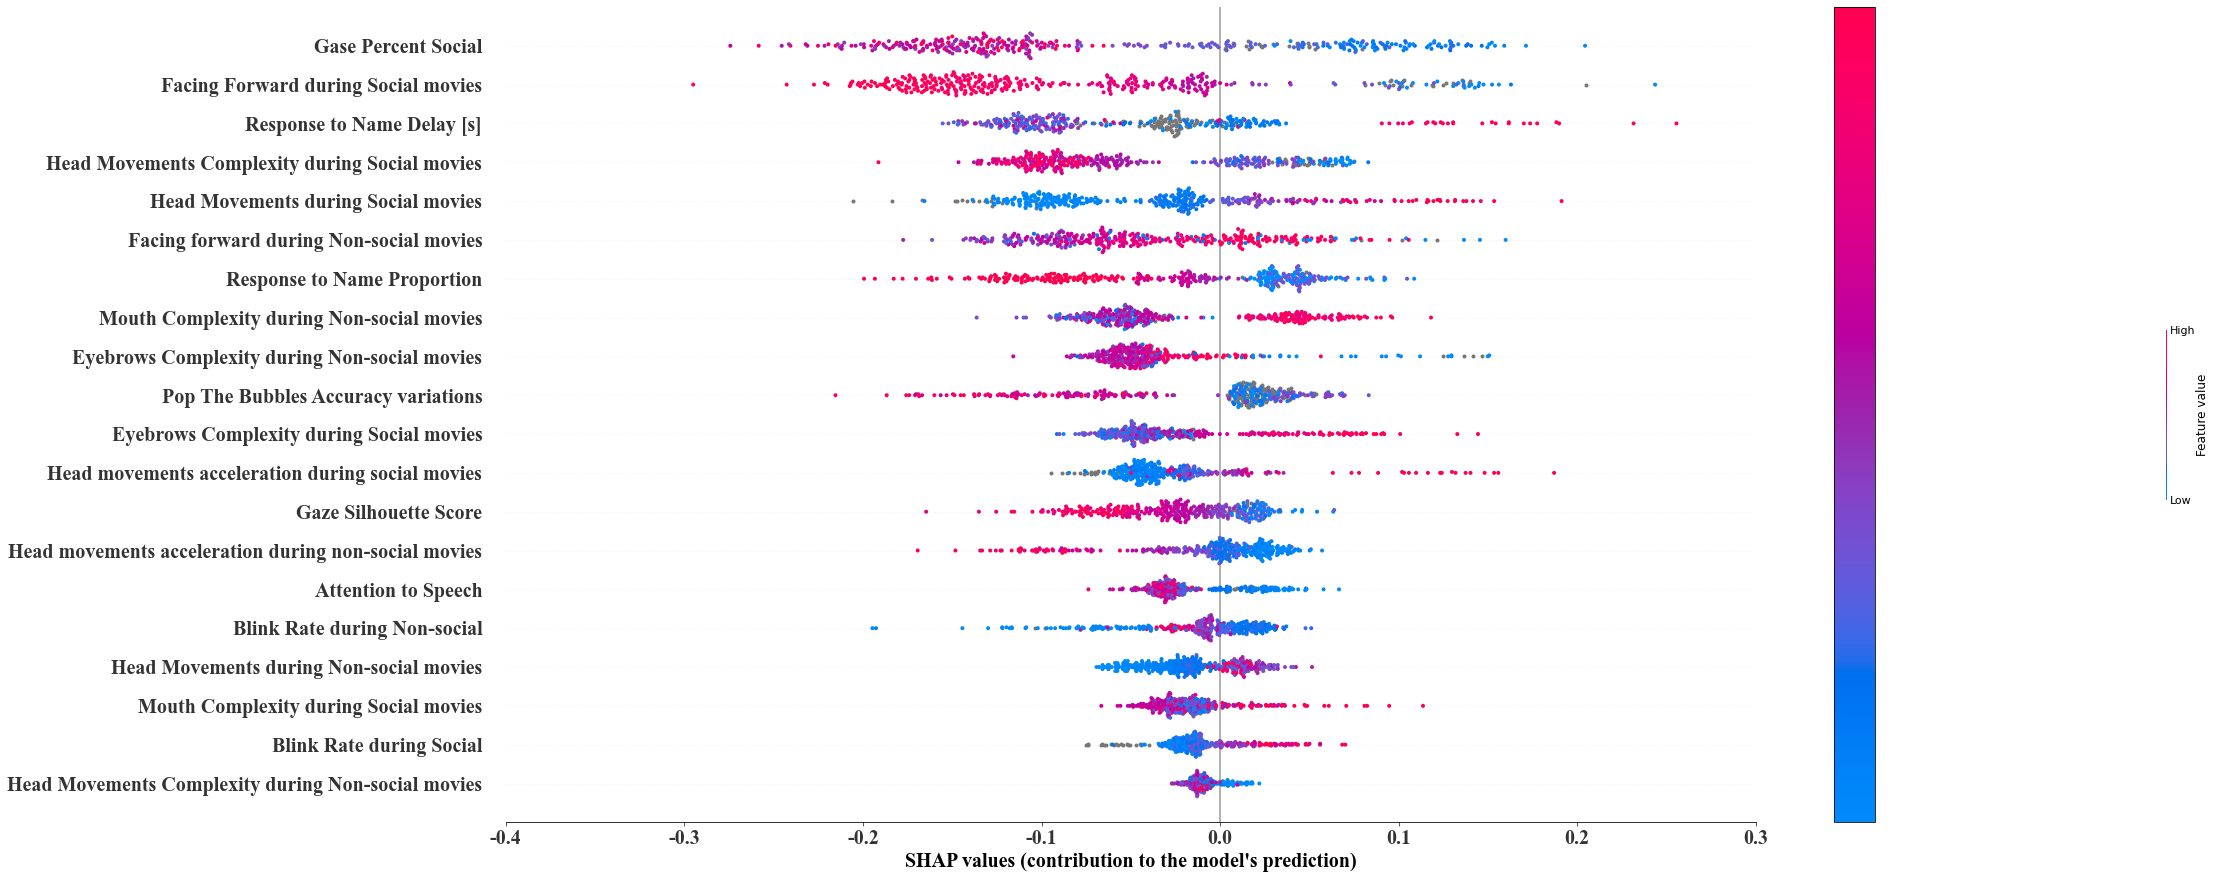

In [226]:
import shap
fig = shap.summary_plot(shap_values_averaged_n, exp.dataset._X_train, feature_names = [feature_name_mapping[f] for f in exp.features_name], plot_size=(35, 15), show=False)# plot_type='bar')

ax= plt.gca()
list_labels = [l._text for l in  ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks(), list_labels, weight='bold', fontsize=20, **csfont)
ax.set_xticks(ax.get_xticks(), np.round(ax.get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
ax.set_xlabel("SHAP values (contribution to the model's prediction)", weight='bold', fontsize=20, **csfont)
      
ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')
plt.colorbar(ticks=range(6), label='')

plt.savefig(os.path.join(ROOT_DIR, 'figures', 'features_importance.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [228]:
[(feat, val) for feat, val in zip(exp.features_name, np.round(np.abs(shap_values_averaged_n).mean(axis=0)*100, 2))]

[('mean_gaze_percent_right', 11.13),
 ('gaze_silhouette_score', 3.38),
 ('FP_gaze_speech_correlation', 2.75),
 ('proportion_of_name_call_responses', 5.95),
 ('average_response_to_name_delay', 6.98),
 ('S_postural_sway', 6.45),
 ('NS_postural_sway', 2.53),
 ('S_postural_sway_derivative', 4.0),
 ('NS_postural_sway_derivative', 2.81),
 ('S_postural_sway_complexity', 6.9),
 ('NS_postural_sway_complexity', 1.1),
 ('S_blink_rate', 2.08),
 ('NS_blink_rate', 2.65),
 ('S_facing_forward', 11.08),
 ('NS_facing_forward', 6.14),
 ('S_eyebrows_complexity', 4.37),
 ('NS_eyebrows_complexity', 4.85),
 ('S_mouth_complexity', 2.35),
 ('NS_mouth_complexity', 5.33),
 ('pop_rate', 0.98),
 ('std_error', 4.8),
 ('average_length', 0.53),
 ('average_force_applied', 0.89)]

**We now disembiguate the missing and present shap valeus for each samples using masking**

In [229]:
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

**Concatenate shap value separating real variables and when there are missing. Note that we did not lost the normalization**

In [230]:
general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)

np.abs(general_shap_values).sum(axis=1).mean()

1.0

**We now normalize the absolute Shap values over samples, and average them, to have the Final features importances per variables + per missingness.**

In [231]:
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]


In [232]:
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()
np.abs(features_importances_extended).sum(axis=0)

1.0

**We now visualize the features contribution of the present variables and the contributions of the missing ones**

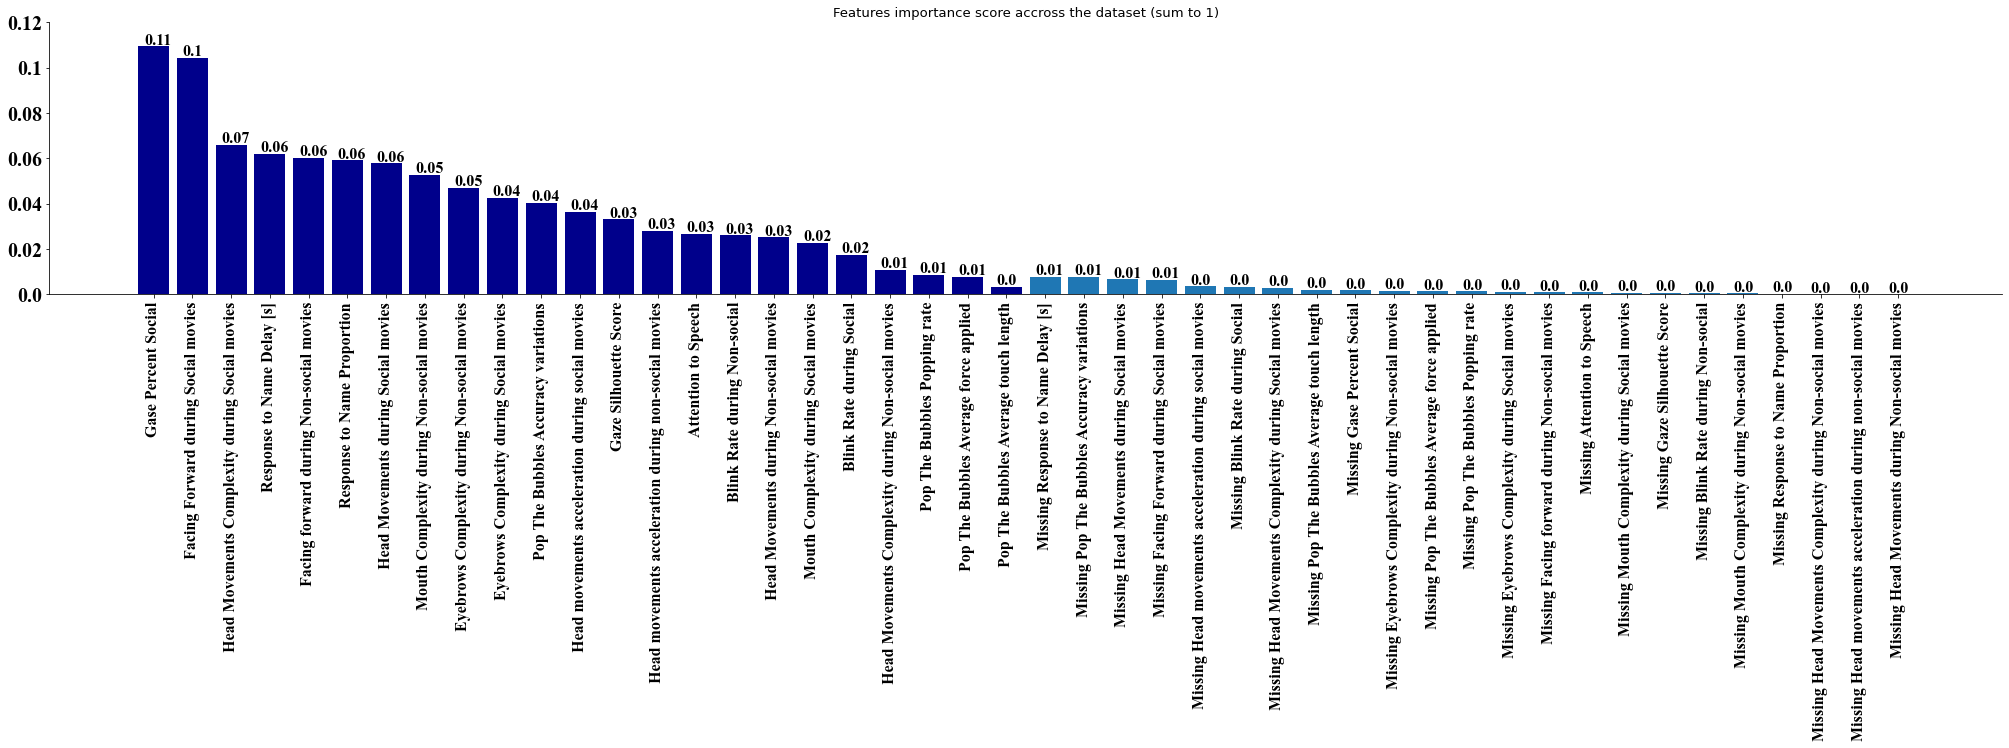

In [233]:
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))
offset=0.001
fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='darkblue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_present][i], 2)), (i-.25, features_importances_extended[idx_sorting_present][i] + offset), weight='bold', fontsize=16, **csfont)
    
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_missing][i], 2)), (j-.25, features_importances_extended[idx_sorting_missing][i] + offset), weight='bold', fontsize=16, **csfont)
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels= [feature_name_mapping[f] if f[0] != 'Z' else "Missing " + feature_name_mapping[f[2:]] for f in np.array(labels)[idx_sorting]], rotation =90, weight='bold', fontsize=16, **csfont)
#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'features_importance_present_missing.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

In [234]:
general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()

0.13251025242374023

**What is the global contribution to the missing variables to the model ?**

In [235]:
percent_missing_importance_mean = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).mean()*100
percent_missing_importance_std = general_shap_values_normalized[:, len(exp.features_name):].sum(axis=1).std()*100

print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

The average (std) contribution of the variables being missing are: 5.17% (+/- 13.25%)


**Which feature missingness is the most important overall ?**

In [236]:
general_shap_values_normalized[:, len(exp.features_name):].mean(axis=0)

array([1.76651793e-03, 7.07467787e-04, 9.40778781e-04, 2.47118154e-04,
       7.70939605e-03, 6.60357151e-03, 0.00000000e+00, 3.46163492e-03,
       0.00000000e+00, 2.85434489e-03, 8.39885376e-05, 3.39604480e-03,
       5.35006380e-04, 6.38195043e-03, 9.65767982e-04, 1.19290334e-03,
       1.45869254e-03, 7.66584022e-04, 4.50534423e-04, 1.23976893e-03,
       7.68405848e-03, 1.99298318e-03, 1.26364327e-03])

In [237]:
general_shap_values_normalized[:, len(exp.features_name):].std(axis=0)

array([0.00925574, 0.0033544 , 0.00429278, 0.00305843, 0.01608382,
       0.03001708, 0.        , 0.01562467, 0.        , 0.01179212,
       0.00085911, 0.01349411, 0.00732887, 0.02700079, 0.00961815,
       0.00505204, 0.01411059, 0.0033852 , 0.00463301, 0.0021704 ,
       0.0120229 , 0.00341169, 0.00203796])

In [238]:
exp.features_name[11]

'S_blink_rate'

**Which feature missingness is the most important overall ? Now we detail the analysis only accounting for the participants having the feature missing (for each feature). This allow for instance to say: among all the participant who miss feature X, the average contribution of missing this feature where Y.**

In [114]:
mean_contribution_missing = [] 
std_contribution_missing = []
for i, feature_name in enumerate(exp.features_name):
    print(feature_name, len(np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten()))
    
    
    
    mean_contribution_missing.append(general_shap_values_normalized[:, len(exp.features_name):][np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten(), i].mean())
    std_contribution_missing.append(general_shap_values_normalized[:, len(exp.features_name):][np.argwhere(np.isnan(exp.dataset._X_train[:, i])).flatten(), i].std())

mean_contribution_missing = np.array(mean_contribution_missing)
mean_contribution_missing[np.isnan(np.array(mean_contribution_missing))] = 0


std_contribution_missing = np.array(std_contribution_missing)
std_contribution_missing[np.isnan(np.array(std_contribution_missing))] = 0

mean_gaze_percent_right 24
gaze_silhouette_score 24
FP_gaze_speech_correlation 28
proportion_of_name_call_responses 4
average_response_to_name_delay 118
S_postural_sway 22
NS_postural_sway 0
S_postural_sway_derivative 22
NS_postural_sway_derivative 0
S_postural_sway_complexity 42
NS_postural_sway_complexity 20
S_blink_rate 28
NS_blink_rate 3
S_facing_forward 41
NS_facing_forward 20
S_eyebrows_complexity 42
NS_eyebrows_complexity 20
S_mouth_complexity 42
NS_mouth_complexity 20
pop_rate 167
std_error 173
average_length 167
average_force_applied 173


In [115]:
mean_contribution_missing

array([0.05357651, 0.050817  , 0.01627778, 0.03101455, 0.02205659,
       0.19587599, 0.        , 0.0467692 , 0.        , 0.0370709 ,
       0.00607968, 0.00473921, 0.1621579 , 0.09162684, 0.02533321,
       0.04569226, 0.0226763 , 0.03170523, 0.0518766 , 0.01121281,
       0.02542138, 0.00539599, 0.00311838])

In [116]:
general_shap_values_normalized[:, len(exp.features_name):].std(axis=0)

array([0.01253967, 0.01136063, 0.00419747, 0.00311701, 0.0115822 ,
       0.04170687, 0.        , 0.00997138, 0.        , 0.01093634,
       0.00139323, 0.00153851, 0.01323753, 0.02613272, 0.00631076,
       0.01361294, 0.00520673, 0.00945512, 0.01099468, 0.00579871,
       0.01394847, 0.00402738, 0.00222153])

In [117]:
exp.features_name[14]

'NS_facing_forward'

**Conclusion:**

When missing, it is the Eyebrows complexity (missing)  that were themost important, with an average contribution of around 15%. However, this only concerns 4 cases...

0.13663403617279396

**For the computation of the compliance score, we are now interested only in the features that are present, and without the indicator variables.**

There are not normalized so we first need to renormalized them (some importance were allocated to the missing variables and Z)

In [239]:
shap_present_real_variables = shap_present[:, :23]
np.abs(shap_present_real_variables).sum(axis=1).mean()

0.9482972436564855

In [240]:
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
np.abs(shap_present_normalized).sum(axis=1).mean()

1.0

**We now average over the participants to get th importance of the present variables to the model**

In [241]:
features_importance_present_n = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()
features_importance_present_n.shape

(23,)

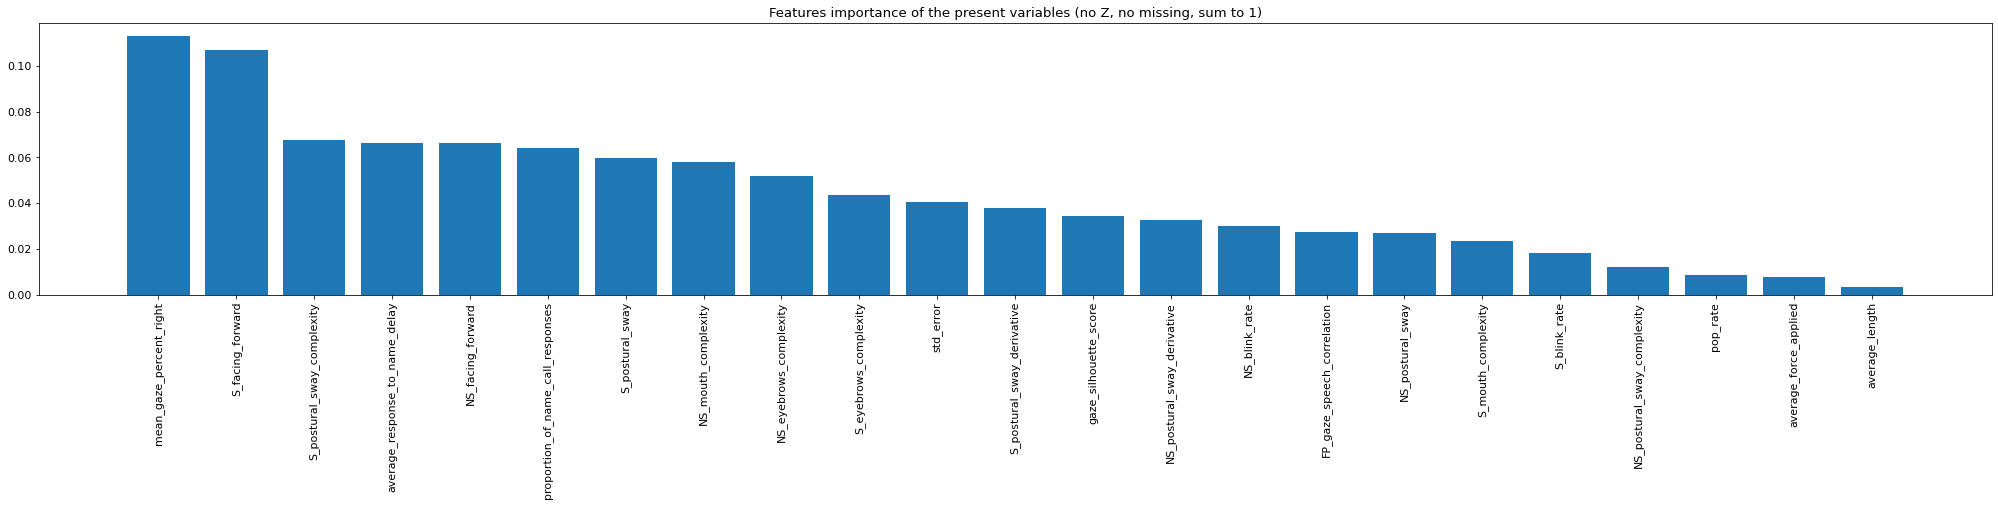

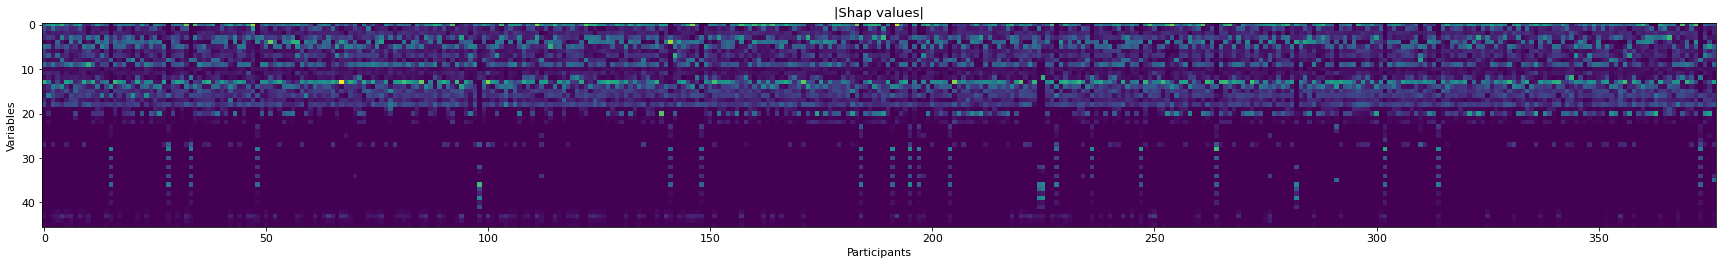

In [242]:
idx_ordered = list(reversed(np.argsort(features_importance_present_n)))

fi(35, 5)
plt.title("Features importance of the present variables (no Z, no missing, sum to 1)")
for i, (idx, feat) in enumerate(zip(idx_ordered, np.array(exp.features_name[:23])[idx_ordered])):
    plt.bar(i, features_importance_present_n[idx], color='tab:blue')
plt.xticks(ticks = np.arange(features_importance_present_n.shape[0]), labels=np.array(exp.features_name[:23])[idx_ordered], rotation =90)
None


fi(30, 35)
plt.title("|Shap values|")
plt.imshow(general_shap_values_normalized.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

**We can store the importance of each of the features to the model**

This is super useful when we extend the cohort or use the DDLD, we can therefore directly use this, the confidence score of each snew samples (computed from their available data), and so compute the compiance score of each participant. 

In [243]:
features_importance_present_n

array([0.11315872, 0.03425091, 0.02745568, 0.06393428, 0.06642852,
       0.0596584 , 0.02699794, 0.03768584, 0.03267748, 0.06757193,
       0.01196459, 0.0180624 , 0.02994581, 0.10705289, 0.06642611,
       0.04341091, 0.05191672, 0.02326756, 0.05782543, 0.0086236 ,
       0.04053777, 0.00334531, 0.00780119])

In [244]:
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'features_importance_present_n.npy'), features_importance_present_n)

# Building W the matrix of confidence in the different measure


In this section we aim at weighting the confidence we have in each of the input. The weight are between 0 and 1. This is an initial potentially naive way ay of weigthing the features confidences.
- For features that are an aggregation of the same feature over multiple videos, we use linear weighting (1 is all measures are available 0 otherwise, with linear mapping between these extremes).
- For the name call variables, we use the number of valid name call experiemnts. This can be 0, 1, 2, or 3. If 0 valid name call experiment, we set the weigths to 0. If there are at least one valid experiement, we still may or not ghave the information of the delay. In this case there are two scenraio that have been discussed. Either the participant answered and so the weighting is the same as the proportion of valid name call. If the participant did not answer, there is no "delay experiment", and so we set it to 0 (and not to the proportion...).
- For the touch variables, a measure of confidence we may have on the different variables could be proportional to the number of touches, with a maxmum confidence when the number of touches is higher than e.g. 15. 

For missing features, we let their weight to be 0, as we don't have the information of their value, but set to 1 the weight attributed to the indicator variable of its missingness (as xgboost handles missing data, it still uses the information of that feature being missing, so this information is accouted for).


There are two ways we can use these weights. 
1) During training and inference, we weight the input matrix by these weights, which influence the weighting of the gradient and hessian statiastics of the different optimization steps. 
2) More complex, using Bayesian ideas. We can see the input features as gaussians, with for instance a sigma parameter close to 0 if we have some certainty about the measure, and larger (value depends on the feature range etc), for input we are not to sure about.



In [245]:

if True:
    
    exp.dataset.df['S_blink_rate_conf'] = (~exp.dataset.df[['MML_blink_rate', 'FP_blink_rate', 'PWB_blink_rate']].isna()).sum(axis=1)/3
    exp.dataset.df['NS_blink_rate_conf'] = (~exp.dataset.df[['DIGC_blink_rate', 'DIGRRL_blink_rate', 'FB_blink_rate', 'MP_blink_rate']].isna()).sum(axis=1)/4

    
    exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway', 'PWB_postural_sway']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
   
    exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative', 'PWB_postural_sway_derivative']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
    
    exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
    exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2
    exp.dataset.df['FP_gaze_speech_correlation_conf'] = (~exp.dataset.df[['FP_gaze_speech_correlation']].isna()).sum(axis=1)

    exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward', 'PWB_facing_forward']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

    exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity', 'PWB_eyebrows_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity', 'PWB_mouth_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity', 'PWB_head_movement_complexity']].isna()).sum(axis=1)/5
    exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


    exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
    exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)




if False:

    exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
    exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
    exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
    exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2
    exp.dataset.df['FP_gaze_speech_correlation_conf'] = (~exp.dataset.df[['FP_gaze_speech_correlation']].isna()).sum(axis=1)

    exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

    exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

    exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity']].isna()).sum(axis=1)/4
    exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


    exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
    exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)


for conf_col in ['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf', 'NS_postural_sway_derivative_conf',
                 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 'proportion_of_name_call_responses_conf', 'average_response_to_name_delay_conf', 'touch_conf']:
    
    pass#exp.dataset.df.loc[exp.dataset.df[conf_col]==0, conf_col] = 1
    

conf_values = np.zeros((exp.dataset.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = exp.dataset.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['RTN_conf']
            
    else:
        conf_values[:, i] = exp.dataset.df['{}_conf'.format(feat)]
        
    

In [246]:
exp.dataset._X_train.shape

(377, 23)

In [247]:
    
# ----------------- Shanity check: show the values that are missing but don't have a confidence set to 0 (should not be the case) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere((mask_shap_present.astype(int)==0).astype(int) == 1):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if conf_values[coord[0]][coord[1]] != 0 :
        print(coord, conf_values[coord[0]][coord[1]], exp.dataset._X_train[coord[0]][coord[1]])
        
        
# ----------------- Shanity check: show the values that have a confidence of 0 but are not msising (should only be the case for the RTN delay if no valid NC) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere(conf_values==0):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if not np.isnan(exp.dataset._X_train[coord[0]][coord[1]]):
        if exp.features_name[coord[1]] != 'average_response_to_name_delay':
            print(coord, exp.dataset._X_train[coord[0]][coord[1]], exp.features_name[coord[1]])
            
            

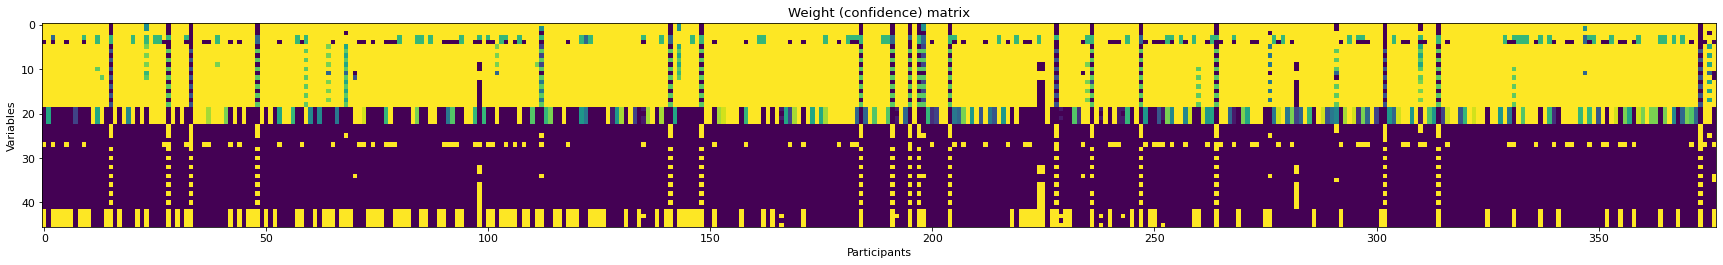

In [248]:
            
# --------------- Add the weights asssociated with the missingness ---------------------- #
conf_values = np.concatenate([conf_values, np.isnan(exp.dataset._X_train).astype(int)], axis=1)

fi(30, 35)
plt.title("Weight (confidence) matrix")
plt.imshow(conf_values.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

In [85]:
# Experimental ...

#exp.dataset.df['Measures Confidence Uniform'] = exp.dataset.df[['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf',
#                                                        'NS_postural_sway_derivative_conf', 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 
 #                                                       'RTN_conf', 'touch_conf']].sum(axis=1)/8


#exp.dataset.df['Measures Confidence Weighted'] =  conf_values[:, :12].sum(axis=1)/12

# Computation of a quality score for each of the participants


Now that we computed the relative contribution of each features (and their missingness) for each participants, $G(X)$, and a confidence score associated in each of the variables, $W(X)$, we can compute a general confidence score on the prediction based on the initial information we had on each sample. 

The way to think about it seems to be: okay we had a certain distribution of confidence across the variables, they all have different importance to make the final prediction, what is the final confidence we have for a sample ? 


$$ Quality (X^i) = \sum_{k=0}^K G(X^i_k) W(X^i_k) $$




This quality has value between 0 and 1, with 1 when all features are available.general_shap_values_normalized

In [249]:
features_importance_present_n

array([0.11315872, 0.03425091, 0.02745568, 0.06393428, 0.06642852,
       0.0596584 , 0.02699794, 0.03768584, 0.03267748, 0.06757193,
       0.01196459, 0.0180624 , 0.02994581, 0.10705289, 0.06642611,
       0.04341091, 0.05191672, 0.02326756, 0.05782543, 0.0086236 ,
       0.04053777, 0.00334531, 0.00780119])

In [250]:
weighted_confidence_score = np.multiply(conf_values[:,:len(features_importance_present_n)], features_importance_present_n).sum(axis=1)
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'), weighted_confidence_score)

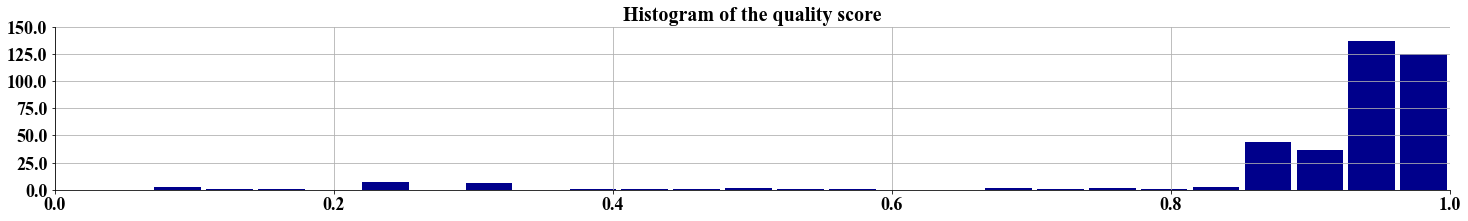

In [251]:
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score.flatten(), color='darkblue', bins=25, rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')



None

**Now that we have the weigth we try to see whetehr it improves the performances.**

In [253]:
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
K = 100

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   positive_class = [1],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='25_Janvier_Final_Importance_Computation_with_pwb_with_weighting', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    
    

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 1!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                0  0.859   0.564        0.916             0.219                  0.949                           0.667               0.183  0.667         0.338     0.836                                   0.491                                              0.776                                                       0.845                                            0.427                                              0.104                                 0.962                                   0.224                             0.573                            0.038  38  277  51  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 2!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                1  0.853   0.573        0.918             0.303                  0.987                           0.671               0.164  0.671         0.315     0.812                                   0.475                                              0.816                                                       0.811                                            0.392                                              0.091                                 0.967                                   0.184                             0.608                            0.033  40  266  62   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 3!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                2  0.862   0.566        0.909             0.221                  0.963                           0.672               0.295  0.672          0.45     0.899                                   0.586                                              0.694                                                        0.93                                            0.596                                              0.187                                 0.953                                   0.306                             0.404                            0.047  34  305  23  15

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 4!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                3  0.859    0.58        0.925             0.304                  0.988                            0.67               0.154  0.67         0.301     0.796                                   0.463                                              0.837                                                        0.79                                            0.373                                              0.085                                  0.97                                   0.163                             0.627                             0.03  41  259  69   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 5!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                4  0.868   0.606        0.936             0.315                   0.99                           0.668               0.152  0.668         0.299     0.793                                    0.46                                              0.837                                                       0.787                                            0.369                                              0.084                                  0.97                                   0.163                             0.631                             0.03  41  258  70   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 6!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                5  0.883    0.61        0.933              0.25                  0.948                           0.683               0.148  0.683         0.296     0.782                                   0.467                                              0.878                                                       0.768                                            0.361                                              0.081                                 0.977                                   0.122                             0.639                            0.023  43  252  76   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 7!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                6  0.859   0.564        0.916             0.219                  0.949                           0.667               0.183  0.667         0.338     0.836                                   0.491                                              0.776                                                       0.845                                            0.427                                              0.104                                 0.962                                   0.224                             0.573                            0.038  38  277  51  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 8!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                7   0.86   0.552        0.921             0.207                  0.927                           0.666                0.15  0.666         0.296      0.79                                   0.456                                              0.837                                                       0.784                                            0.366                                              0.082                                  0.97                                   0.163                             0.634                             0.03  41  257  71   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 9!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                8  0.865   0.545        0.903             0.229                   0.98                           0.676               0.131  0.676          0.27     0.745                                   0.446                                              0.918                                                        0.72                                            0.328                                              0.071                                 0.983                                   0.082                             0.672                            0.017  45  236  92   4

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 10!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0                9  0.878   0.574        0.922             0.218                  0.946                           0.714               0.186  0.714         0.351     0.833                                   0.526                                              0.857                                                       0.829                                            0.429                                              0.105                                 0.975                                   0.143                             0.571                            0.025  42  272  56   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 11!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               10  0.845   0.545        0.898             0.243                  0.982                           0.665               0.197  0.665         0.354     0.849                                   0.504                                              0.755                                                       0.863                                            0.451                                              0.113                                 0.959                                   0.245                             0.549                            0.041  37  283  45  12

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 12!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               11  0.896   0.653        0.953             0.366                  0.993                           0.705               0.167  0.705         0.324     0.809                                   0.502                                              0.878                                                       0.799                                            0.394                                              0.092                                 0.978                                   0.122                             0.606                            0.022  43  262  66   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 13!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               12  0.893   0.596        0.915             0.262                  0.984                           0.727               0.216  0.727          0.39     0.833                                   0.536                                              0.878                                                       0.826                                             0.43                                              0.105                                 0.978                                   0.122                              0.57                            0.022  43  271  57   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 14!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               13  0.871   0.545        0.909              0.19                  0.903                           0.709               0.208  0.709         0.376     0.854                                   0.542                                              0.816                                                        0.86                                            0.465                                              0.119                                 0.969                                   0.184                             0.535                            0.031  40  282  46   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 15!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               14  0.856   0.562        0.927             0.214                  0.947                           0.655               0.142  0.655         0.283     0.777                                    0.44                                              0.837                                                       0.768                                             0.35                                              0.077                                 0.969                                   0.163                              0.65                            0.031  41  252  76   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 16!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               15  0.861   0.532        0.913             0.178                  0.938                           0.648               0.209  0.648         0.363     0.859                                   0.504                                              0.714                                                       0.881                                            0.473                                              0.123                                 0.954                                   0.286                             0.527                            0.046  35  289  39  14

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 17!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               16  0.864    0.52        0.895             0.172                  0.893                           0.668               0.172  0.668         0.324     0.822                                    0.48                                              0.796                                                       0.826                                            0.406                                              0.096                                 0.964                                   0.204                             0.594                            0.036  39  271  57  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 18!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               17  0.878   0.578         0.92             0.243                   0.98                           0.717               0.219  0.717          0.39     0.862                                   0.556                                              0.816                                                       0.869                                            0.482                                              0.126                                 0.969                                   0.184                             0.518                            0.031  40  285  43   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 19!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               18  0.861   0.561         0.91             0.224                  0.967                           0.682                0.13  0.682          0.27      0.74                                   0.451                                              0.939                                                        0.71                                            0.326                                               0.07                                 0.987                                   0.061                             0.674                            0.013  46  233  95   3

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 20!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               19  0.884     0.6        0.933             0.266                  0.982                           0.712               0.184  0.712         0.348      0.83                                   0.522                                              0.857                                                       0.826                                            0.424                                              0.103                                 0.975                                   0.143                             0.576                            0.025  42  271  57   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 21!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               20  0.883   0.593        0.923              0.26                  0.984                           0.694               0.157  0.694         0.309     0.796                                   0.484                                              0.878                                                       0.784                                            0.377                                              0.086                                 0.977                                   0.122                             0.623                            0.023  43  257  71   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 22!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               21  0.864   0.542        0.908              0.19                  0.925                           0.665               0.197  0.665         0.354     0.849                                   0.504                                              0.755                                                       0.863                                            0.451                                              0.113                                 0.959                                   0.245                             0.549                            0.041  37  283  45  12

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 23!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               22  0.867   0.608        0.934             0.311                   0.99                           0.694               0.203  0.694         0.368     0.851                                   0.528                                              0.796                                                        0.86                                            0.459                                              0.117                                 0.966                                   0.204                             0.541                            0.034  39  282  46  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 24!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               23  0.859   0.576        0.923              0.24                  0.967                            0.66               0.139  0.66         0.279     0.769                                   0.441                                              0.857                                                       0.756                                            0.344                                              0.076                                 0.973                                   0.143                             0.656                            0.027  42  248  80   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 25!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               24  0.869   0.568        0.919             0.231                  0.968                           0.707               0.222  0.707         0.391     0.865                                   0.552                                              0.796                                                       0.875                                            0.488                                              0.129                                 0.966                                   0.204                             0.512                            0.034  39  287  41  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 26!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               25  0.881   0.614        0.936             0.297                  0.989                           0.676               0.169  0.676         0.322     0.817                                   0.482                                              0.816                                                       0.817                                              0.4                                              0.094                                 0.968                                   0.184                               0.6                            0.032  40  268  60   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 27!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               26  0.859   0.586        0.917             0.286                  0.987                           0.661               0.191  0.661         0.346     0.844                                   0.494                                              0.755                                                       0.857                                             0.44                                              0.109                                 0.959                                   0.245                              0.56                            0.041  37  281  47  12

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 28!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN   FP  FN
0               27  0.858   0.544        0.896             0.227                  0.977                           0.643               0.118  0.643         0.246     0.716                                   0.405                                              0.898                                                       0.689                                            0.301                                              0.063                                 0.978                                   0.102                             0.699                            0.022  44  226  102   5

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 29!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               28  0.887   0.626        0.942             0.323                  0.991                           0.712               0.184  0.712         0.348      0.83                                   0.522                                              0.857                                                       0.826                                            0.424                                              0.103                                 0.975                                   0.143                             0.576                            0.025  42  271  57   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 30!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               29  0.876   0.554        0.909             0.195                  0.938                           0.703                0.15  0.703         0.301      0.78                                   0.485                                              0.918                                                       0.759                                            0.363                                              0.081                                 0.984                                   0.082                             0.637                            0.016  45  249  79   4

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 31!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               30  0.872   0.525        0.889             0.169                  0.941                           0.712               0.196  0.712         0.363     0.844                                   0.533                                              0.837                                                       0.845                                            0.446                                              0.111                                 0.972                                   0.163                             0.554                            0.028  41  277  51   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 32!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               31  0.861   0.565         0.91             0.247                  0.983                            0.66               0.132  0.66         0.269     0.753                                   0.433                                              0.878                                                       0.735                                            0.331                                              0.071                                 0.976                                   0.122                             0.669                            0.024  43  241  87   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 33!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               32  0.872   0.615        0.936             0.319                   0.99                           0.722               0.195  0.722         0.363     0.841                                   0.539                                              0.857                                                       0.838                                            0.442                                               0.11                                 0.975                                   0.143                             0.558                            0.025  42  275  53   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 34!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               33  0.869   0.588        0.921              0.28                  0.987                           0.677               0.152  0.677           0.3      0.79                                   0.467                                              0.857                                                        0.78                                            0.368                                              0.083                                 0.973                                   0.143                             0.632                            0.027  42  256  72   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 35!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               34  0.877   0.556        0.914             0.199                  0.939                           0.679               0.199  0.679         0.359     0.849                                   0.513                                              0.776                                                        0.86                                            0.452                                              0.114                                 0.962                                   0.224                             0.548                            0.038  38  282  46  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 36!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               35  0.875   0.551        0.905             0.222                  0.978                           0.714               0.166  0.714         0.325     0.806                                   0.508                                              0.898                                                       0.793                                            0.393                                              0.092                                 0.981                                   0.102                             0.607                            0.019  44  260  68   5

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 37!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               36  0.875   0.597        0.932             0.301                  0.989                           0.687               0.181  0.687         0.339     0.801                                   0.481                                              0.857                                                       0.793                                            0.382                                              0.088                                 0.974                                   0.143                             0.618                            0.026  42  260  68   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 38!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               37   0.87   0.584        0.921             0.256                  0.981                           0.682               0.188  0.682         0.347     0.838                                   0.505                                              0.796                                                       0.845                                            0.433                                              0.106                                 0.965                                   0.204                             0.567                            0.035  39  277  51  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 39!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               38  0.869   0.591        0.924             0.299                  0.988                            0.68               0.147  0.68         0.293      0.78                                   0.464                                              0.878                                                       0.765                                            0.358                                               0.08                                 0.977                                   0.122                             0.642                            0.023  43  251  77   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 40!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               39  0.873   0.562        0.911              0.22                  0.966                           0.695               0.167  0.695         0.324     0.812                                   0.495                                              0.857                                                       0.805                                            0.396                                              0.093                                 0.974                                   0.143                             0.604                            0.026  42  264  64   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 41!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected   F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               40  0.872    0.59        0.918             0.277                  0.987                             0.7               0.182  0.7         0.344      0.83                                   0.512                                              0.837                                                       0.829                                            0.423                                              0.102                                 0.971                                   0.163                             0.577                            0.029  41  272  56   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 42!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               41  0.858   0.528        0.903             0.179                  0.943                           0.655                0.13  0.655         0.265     0.748                                   0.427                                              0.878                                                       0.729                                            0.326                                               0.07                                 0.976                                   0.122                             0.674                            0.024  43  239  89   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 43!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               42  0.866   0.582        0.923              0.29                  0.988                           0.687               0.152  0.687         0.301     0.788                                   0.474                                              0.878                                                       0.774                                            0.368                                              0.083                                 0.977                                   0.122                             0.632                            0.023  43  254  74   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 44!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               43  0.861   0.549        0.917             0.193                  0.926                           0.654               0.135  0.654         0.272     0.761                                   0.432                                              0.857                                                       0.747                                            0.336                                              0.073                                 0.972                                   0.143                             0.664                            0.028  42  245  83   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 45!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               44  0.869   0.542        0.901             0.208                  0.965                           0.675                0.15  0.675         0.297     0.788                                   0.463                                              0.857                                                       0.777                                            0.365                                              0.082                                 0.973                                   0.143                             0.635                            0.027  42  255  73   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 46!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               45  0.872   0.582        0.909             0.228                  0.962                           0.674               0.192  0.674          0.35     0.844                                   0.504                                              0.776                                                       0.854                                            0.442                                               0.11                                 0.962                                   0.224                             0.558                            0.038  38  280  48  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 47!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected   F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               46  0.871   0.502        0.862             0.182                  0.933                             0.7               0.172  0.7          0.33     0.817                                   0.503                                              0.857                                                       0.811                                            0.404                                              0.095                                 0.974                                   0.143                             0.596                            0.026  42  266  62   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 48!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               47  0.883   0.562        0.909             0.199                  0.923                           0.699               0.195  0.699         0.359     0.844                                   0.524                                              0.816                                                       0.848                                            0.444                                              0.111                                 0.969                                   0.184                             0.556                            0.031  40  278  50   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 49!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               48  0.858   0.557        0.914             0.239                  0.979                           0.657               0.131  0.657         0.267     0.751                                    0.43                                              0.878                                                       0.732                                            0.328                                              0.071                                 0.976                                   0.122                             0.672                            0.024  43  240  88   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 50!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               49  0.884   0.618        0.937             0.313                   0.99                           0.689               0.197  0.689         0.359     0.788                                   0.474                                              0.878                                                       0.774                                            0.368                                              0.083                                 0.977                                   0.122                             0.632                            0.023  43  254  74   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 51!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               50  0.885    0.57        0.905             0.202                  0.939                           0.714               0.199  0.714         0.367     0.846                                   0.538                                              0.837                                                       0.848                                            0.451                                              0.113                                 0.972                                   0.163                             0.549                            0.028  41  278  50   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 52!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               51  0.875   0.597        0.932             0.301                  0.989                           0.687               0.181  0.687         0.339     0.801                                   0.481                                              0.857                                                       0.793                                            0.382                                              0.088                                 0.974                                   0.143                             0.618                            0.026  42  260  68   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 53!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               52  0.878   0.565        0.905             0.227                  0.976                           0.681               0.202  0.681         0.363     0.851                                   0.518                                              0.776                                                       0.863                                            0.458                                              0.116                                 0.963                                   0.224                             0.542                            0.037  38  283  45  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 54!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               53  0.859    0.58        0.925             0.304                  0.988                            0.67               0.154  0.67         0.301     0.796                                   0.463                                              0.837                                                        0.79                                            0.373                                              0.085                                  0.97                                   0.163                             0.627                             0.03  41  259  69   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 55!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               54  0.855   0.532        0.902               0.2                  0.961                           0.664               0.158  0.664         0.306     0.804                                   0.464                                              0.816                                                       0.802                                            0.381                                              0.087                                 0.967                                   0.184                             0.619                            0.033  40  263  65   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 56!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               55  0.871   0.555         0.89             0.236                  0.979                           0.693               0.175  0.693         0.333     0.822                                     0.5                                              0.837                                                        0.82                                             0.41                                              0.098                                 0.971                                   0.163                              0.59                            0.029  41  269  59   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 57!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               56  0.884   0.604        0.919             0.263                  0.978                           0.699               0.195  0.699         0.359     0.844                                   0.524                                              0.816                                                       0.848                                            0.444                                              0.111                                 0.969                                   0.184                             0.556                            0.031  40  278  50   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 58!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               57  0.868   0.587         0.92             0.248                  0.976                           0.698               0.169  0.698         0.327     0.814                                   0.499                                              0.857                                                       0.808                                              0.4                                              0.094                                 0.974                                   0.143                               0.6                            0.026  42  265  63   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 59!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               58  0.866   0.577        0.918             0.263                  0.985                           0.646               0.205  0.646         0.359     0.857                                   0.499                                              0.714                                                       0.878                                            0.467                                               0.12                                 0.954                                   0.286                             0.533                            0.046  35  288  40  14

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 60!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               59   0.88   0.638        0.942              0.33                  0.991                           0.714               0.199  0.714         0.367     0.846                                   0.538                                              0.837                                                       0.848                                            0.451                                              0.113                                 0.972                                   0.163                             0.549                            0.028  41  278  50   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 61!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               60  0.854   0.525        0.901             0.195                  0.957                           0.664               0.158  0.664         0.306     0.804                                   0.464                                              0.816                                                       0.802                                            0.381                                              0.087                                 0.967                                   0.184                             0.619                            0.033  40  263  65   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 62!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               61  0.878   0.565        0.905             0.227                  0.976                           0.681               0.202  0.681         0.363     0.851                                   0.518                                              0.776                                                       0.863                                            0.458                                              0.116                                 0.963                                   0.224                             0.542                            0.037  38  283  45  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 63!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               62  0.876    0.51        0.873             0.149                  0.916                            0.73                0.22  0.73         0.394     0.862                                   0.565                                              0.837                                                       0.866                                            0.482                                              0.127                                 0.973                                   0.163                             0.518                            0.027  41  284  44   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 64!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               63  0.867   0.594        0.925              0.27                  0.985                           0.722               0.249  0.722         0.424     0.881                                   0.584                                              0.796                                                       0.893                                            0.527                                              0.148                                 0.967                                   0.204                             0.473                            0.033  39  293  35  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 65!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               64  0.888   0.603        0.931             0.264                  0.982                           0.682               0.188  0.682         0.347     0.838                                   0.505                                              0.796                                                       0.845                                            0.433                                              0.106                                 0.965                                   0.204                             0.567                            0.035  39  277  51  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 66!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               65  0.875   0.604        0.938             0.254                  0.949                           0.672                0.14  0.672         0.283     0.769                                   0.451                                              0.878                                                       0.753                                            0.347                                              0.076                                 0.976                                   0.122                             0.653                            0.024  43  247  81   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 67!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               66  0.868   0.587        0.922             0.273                  0.986                           0.645               0.142  0.645         0.281      0.78                                   0.432                                              0.816                                                       0.774                                            0.351                                              0.078                                 0.966                                   0.184                             0.649                            0.034  40  254  74   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 68!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               67  0.859   0.538        0.868             0.228                  0.971                           0.669               0.186  0.669         0.342     0.838                                   0.495                                              0.776                                                       0.848                                            0.432                                              0.106                                 0.962                                   0.224                             0.568                            0.038  38  278  50  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 69!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               68  0.869   0.568        0.919             0.231                  0.968                           0.707               0.222  0.707         0.391     0.865                                   0.552                                              0.796                                                       0.875                                            0.488                                              0.129                                 0.966                                   0.204                             0.512                            0.034  39  287  41  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 70!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               69  0.877   0.563        0.917             0.225                  0.968                           0.719               0.192  0.719         0.359     0.838                                   0.535                                              0.857                                                       0.835                                            0.438                                              0.108                                 0.975                                   0.143                             0.562                            0.025  42  274  54   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 71!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               70  0.853   0.525        0.901             0.182                  0.913                           0.651               0.147  0.651         0.289     0.788                                   0.443                                              0.816                                                       0.784                                             0.36                                              0.081                                 0.966                                   0.184                              0.64                            0.034  40  257  71   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 72!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               71  0.876   0.629        0.937             0.316                   0.99                           0.691               0.217  0.691         0.382     0.862                                   0.537                                              0.776                                                       0.875                                            0.481                                              0.126                                 0.963                                   0.224                             0.519                            0.037  38  287  41  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 73!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               72  0.867   0.533        0.897             0.171                  0.939                           0.681               0.202  0.681         0.363     0.851                                   0.518                                              0.776                                                       0.863                                            0.458                                              0.116                                 0.963                                   0.224                             0.542                            0.037  38  283  45  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 74!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               73  0.887   0.585        0.895             0.214                  0.921                           0.717               0.239  0.717         0.413     0.822                                    0.52                                              0.878                                                       0.814                                            0.413                                              0.099                                 0.978                                   0.122                             0.587                            0.022  43  267  61   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 75!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               74  0.863   0.549        0.911             0.211                   0.96                           0.663               0.167  0.663         0.318     0.817                                   0.472                                              0.796                                                        0.82                                            0.398                                              0.093                                 0.964                                   0.204                             0.602                            0.036  39  269  59  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 76!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               75  0.863   0.541        0.908             0.201                  0.944                           0.679               0.185  0.679         0.343     0.836                                   0.501                                              0.796                                                       0.841                                            0.429                                              0.105                                 0.965                                   0.204                             0.571                            0.035  39  276  52  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 77!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               76  0.872   0.541        0.902             0.186                  0.924                           0.675               0.179  0.675         0.335      0.83                                   0.492                                              0.796                                                       0.835                                            0.419                                              0.101                                 0.965                                   0.204                             0.581                            0.035  39  274  54  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 78!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               77  0.864   0.502        0.872             0.152                  0.935                            0.71               0.171  0.71         0.331     0.814                                   0.509                                              0.878                                                       0.805                                            0.402                                              0.095                                 0.978                                   0.122                             0.598                            0.022  43  264  64   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 79!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               78  0.873   0.592        0.929             0.236                  0.948                           0.695               0.177  0.695         0.336     0.825                                   0.504                                              0.837                                                       0.823                                            0.414                                              0.099                                 0.971                                   0.163                             0.586                            0.029  41  270  58   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 80!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               79  0.851    0.57        0.906             0.253                  0.982                           0.637                0.24  0.637         0.391     0.878                                   0.525                                              0.673                                                       0.909                                            0.524                                              0.146                                 0.949                                   0.327                             0.476                            0.051  33  298  30  16

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 81!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               80   0.87   0.595        0.939             0.258                  0.949                            0.66               0.154  0.66           0.3     0.798                                   0.457                                              0.816                                                       0.796                                            0.374                                              0.085                                 0.967                                   0.184                             0.626                            0.033  40  261  67   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 82!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               81  0.864   0.483        0.875             0.153                  0.929                           0.679               0.162  0.679         0.313     0.806                                   0.478                                              0.837                                                       0.802                                            0.387                                              0.089                                  0.97                                   0.163                             0.613                             0.03  41  263  65   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 83!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               82  0.874   0.567        0.915             0.231                  0.969                           0.687               0.181  0.687         0.339      0.83                                   0.502                                              0.816                                                       0.832                                            0.421                                              0.102                                 0.968                                   0.184                             0.579                            0.032  40  273  55   9

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 84!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               83  0.862    0.52        0.878             0.187                  0.958                           0.661               0.165  0.661         0.314     0.814                                   0.468                                              0.796                                                       0.817                                            0.394                                              0.092                                 0.964                                   0.204                             0.606                            0.036  39  268  60  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 85!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               84  0.855   0.505        0.885             0.164                  0.892                           0.667               0.143  0.667         0.287     0.777                                    0.45                                              0.857                                                       0.765                                            0.353                                              0.078                                 0.973                                   0.143                             0.647                            0.027  42  251  77   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 86!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               85  0.868   0.587        0.924             0.255                   0.98                           0.649               0.176  0.649         0.326      0.83                                   0.472                                              0.755                                                       0.841                                            0.416                                                0.1                                 0.958                                   0.245                             0.584                            0.042  37  276  52  12

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 87!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               86  0.866   0.602        0.933              0.31                   0.99                           0.672               0.156  0.672         0.304     0.798                                   0.467                                              0.837                                                       0.793                                            0.376                                              0.086                                  0.97                                   0.163                             0.624                             0.03  41  260  68   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 88!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               87  0.879   0.579          0.9             0.254                  0.983                           0.717               0.189  0.717         0.355     0.836                                    0.53                                              0.857                                                       0.832                                            0.433                                              0.106                                 0.975                                   0.143                             0.567                            0.025  42  273  55   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 89!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               88   0.87   0.582        0.919             0.284                  0.987                           0.705               0.167  0.705         0.324     0.809                                   0.502                                              0.878                                                       0.799                                            0.394                                              0.092                                 0.978                                   0.122                             0.606                            0.022  43  262  66   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 90!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               89  0.863   0.588        0.928             0.298                  0.989                           0.668               0.172  0.668         0.324     0.793                                    0.46                                              0.837                                                       0.787                                            0.369                                              0.084                                  0.97                                   0.163                             0.631                             0.03  41  258  70   8

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 91!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               90  0.857   0.528        0.906             0.182                  0.899                           0.662               0.178  0.662         0.331      0.83                                   0.482                                              0.776                                                       0.838                                            0.418                                                0.1                                 0.962                                   0.224                             0.582                            0.038  38  275  53  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 92!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               91   0.87   0.552        0.905             0.184                  0.943                           0.717               0.239  0.717         0.413     0.875                                   0.573                                              0.796                                                       0.887                                            0.513                                              0.141                                 0.967                                   0.204                             0.487                            0.033  39  291  37  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 93!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               92  0.852   0.546        0.912             0.204                  0.945                           0.657               0.173  0.657         0.324     0.825                                   0.474                                              0.776                                                       0.832                                            0.409                                              0.097                                 0.961                                   0.224                             0.591                            0.039  38  273  55  11

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 94!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               93  0.863   0.541        0.908             0.201                  0.944                           0.679               0.185  0.679         0.343     0.836                                   0.501                                              0.796                                                       0.841                                            0.429                                              0.105                                 0.965                                   0.204                             0.571                            0.035  39  276  52  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 95!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               94  0.866   0.596        0.927             0.294                  0.988                           0.666               0.126  0.666          0.26     0.732                                   0.432                                              0.918                                                       0.704                                            0.317                                              0.067                                 0.983                                   0.082                             0.683                            0.017  45  231  97   4

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 96!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected   F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               95  0.884   0.589        0.923             0.232                  0.966                             0.7               0.172  0.7          0.33     0.817                                   0.503                                              0.857                                                       0.811                                            0.404                                              0.095                                 0.974                                   0.143                             0.596                            0.026  42  266  62   7

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 97!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               96  0.861   0.535        0.914             0.178                  0.896                            0.67               0.139  0.67         0.281     0.767                                   0.448                                              0.878                                                        0.75                                            0.344                                              0.075                                 0.976                                   0.122                             0.656                            0.024  43  246  82   6

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 98!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               97  0.874   0.587        0.928             0.245                   0.97                           0.681               0.202  0.681         0.363     0.764                                   0.456                                              0.898                                                       0.744                                            0.344                                              0.075                                  0.98                                   0.102                             0.656                             0.02  44  244  84   5

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 99!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               98  0.856   0.523        0.903             0.183                   0.94                           0.654               0.158  0.654         0.305     0.806                                   0.457                                              0.796                                                       0.808                                            0.382                                              0.088                                 0.964                                   0.204                             0.618                            0.036  39  265  63  10

Saving experiment in folder 25_Janvier_Final_Importance_Computation_with_pwb_with_weighting.
Doing experiment 100!


experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               99  0.879   0.586        0.914             0.268                  0.985                           0.694               0.189  0.694         0.351     0.838                                   0.515                                              0.816                                                       0.841                                            0.435                                              0.107                                 0.968                                   0.184                             0.565                            0.032  40  276  52   9

In [255]:
#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['25_Janvier_Final_Importance_Computation_with_pwb_with_weighting'])#'13_november_bis'])#'November 2022'])

100%|██████████| 101/101 [00:30<00:00,  3.35it/s]


In [211]:
# PERFORMANCES WITHOUT WEIGHTING 


# With BLink without weight with pwb DDLD depth 3 200 est loocv
display(df[['AUROC', 'Sensitivity', 'Specificity']].mean())


conslusiveness_score = []
for i, row in df.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

max_youden, index_threshold, optimal_threshold = find_optimal_threshold_youden(y_true, conslusiveness_score )
display(compute_results(y_true, conslusiveness_score, optimal_threshold)[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

AUROC          0.86866
Sensitivity    0.82989
Specificity    0.80747
dtype: float64

AUROC  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)
?\n(N=377)  0.899                                              0.878                                                       0.805

In [288]:
475-49

426

In [254]:
# PERFORMANCES WITH WEIGHTING 

df = create_autism_df(folder_names = ['25_Janvier_Final_Importance_Computation_with_pwb_with_weighting'])#'13_november_bis'])#'November 2022'])

# With BLink without weight with pwb DDLD depth 3 200 est loocv
display(df[['AUROC', 'Sensitivity', 'Specificity']].mean())


conslusiveness_score = []
for i, row in df.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

max_youden, index_threshold, optimal_threshold = find_optimal_threshold_youden(y_true, conslusiveness_score )
display(compute_results(y_true, conslusiveness_score, optimal_threshold)[['AUROC', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)']])

100%|██████████| 101/101 [00:30<00:00,  3.36it/s]


AUROC          0.86899
Sensitivity    0.82784
Specificity    0.81498
dtype: float64

AUROC  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)
?\n(N=377)  0.895                                              0.837                                                       0.845

**Conclusion**

> We will not use the weighting, since the Younden and AUROC are higher without.

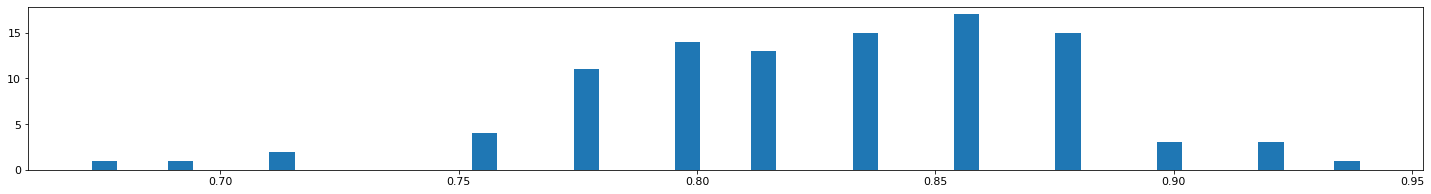

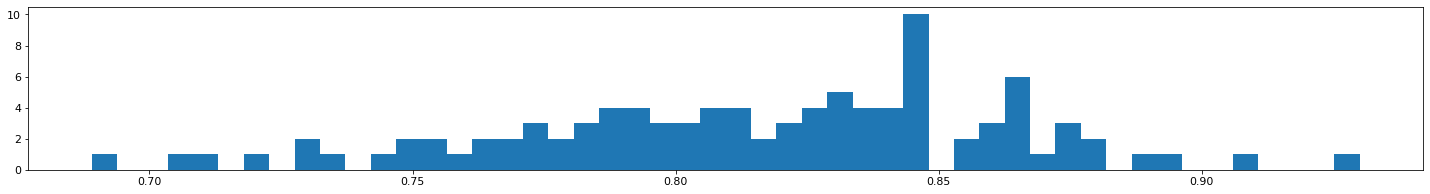

In [258]:
fi(25, 3)
plt.hist(df['Sensitivity'], bins=50)
fi(25, 3)
_ = plt.hist(df['Specificity'], bins=50)

experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected     F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0               99  0.879   0.586        0.914             0.268                  0.985                           0.694               0.189  0.694         0.351     0.838                                   0.515                                              0.816                                                       0.841                                            0.435                                              0.107                                 0.968                                   0.184                             0.565                            0.032  40  276  52   9

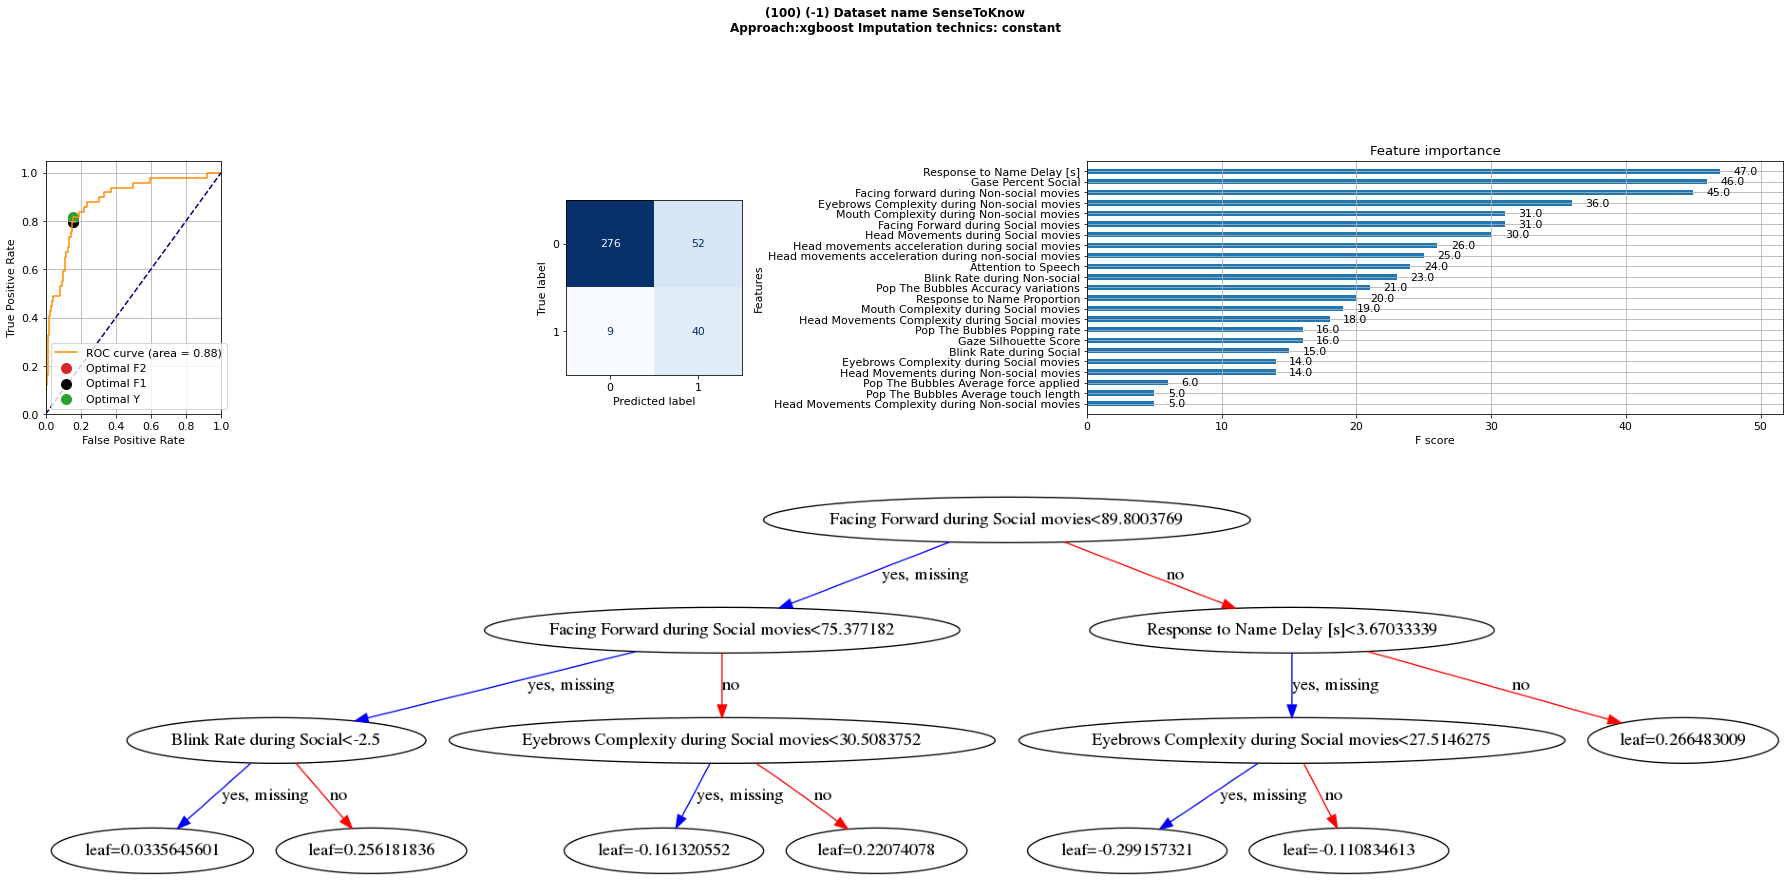

Threshold index  Threshold  Sensitivity  Specificity       PPV  PPV_corr       NPV  NPV_corr
0                 0   1.994596     0.000000     1.000000       NaN       NaN  0.870027  0.977273
1                 1   0.994596     0.020408     1.000000  1.000000  1.000000  0.872340  0.977726
2                 2   0.985997     0.102041     1.000000  1.000000  1.000000  0.881720  0.979544
3                 3   0.985016     0.102041     0.996951  0.833333  0.437683  0.881402  0.979483
4                 4   0.982182     0.122449     0.996951  0.857143  0.482945  0.883784  0.979940
..              ...        ...          ...          ...       ...       ...       ...       ...
61               61   0.001809     0.959184     0.405488  0.194215  0.036164  0.985185  0.997665
62               62   0.001786     0.979592     0.405488  0.197531  0.036905  0.992537  0.998831
63               63   0.000168     0.979592     0.079268  0.137143  0.024145  0.962963  0.994048
64               64   0.000164     1.000000     0.079268  0.139601  0.024636  1.000000  1.000000
65               65   0.000022     1.000000     0.000000  0.129973  0.022727       NaN       NaN

[66 rows x 8 columns]

In [259]:
exp.plot()

# Playing with the scores

In [83]:
exp.predictions_df['conf'] = weighted_confidence_score

(0.0, 1.0)

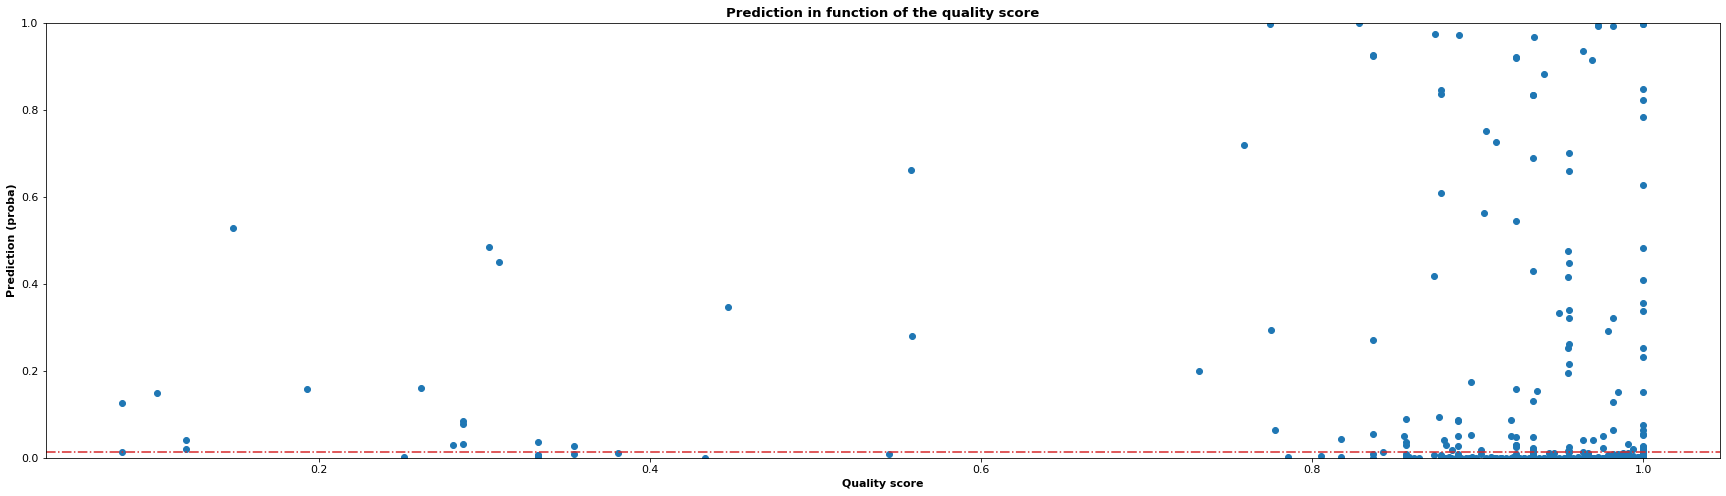

In [84]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']
fi(30, 8);ax=plt.gca()
plt.scatter(exp.predictions_df['conf'].to_numpy(), exp.predictions_df['y_pred'].to_numpy())
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.')
plt.title("Prediction in function of the quality score", weight='bold')
plt.xlabel("Quality score", weight='bold');plt.ylabel("Prediction (proba)", weight='bold')

plt.ylim([0, 1])

(0.0, 1.0)

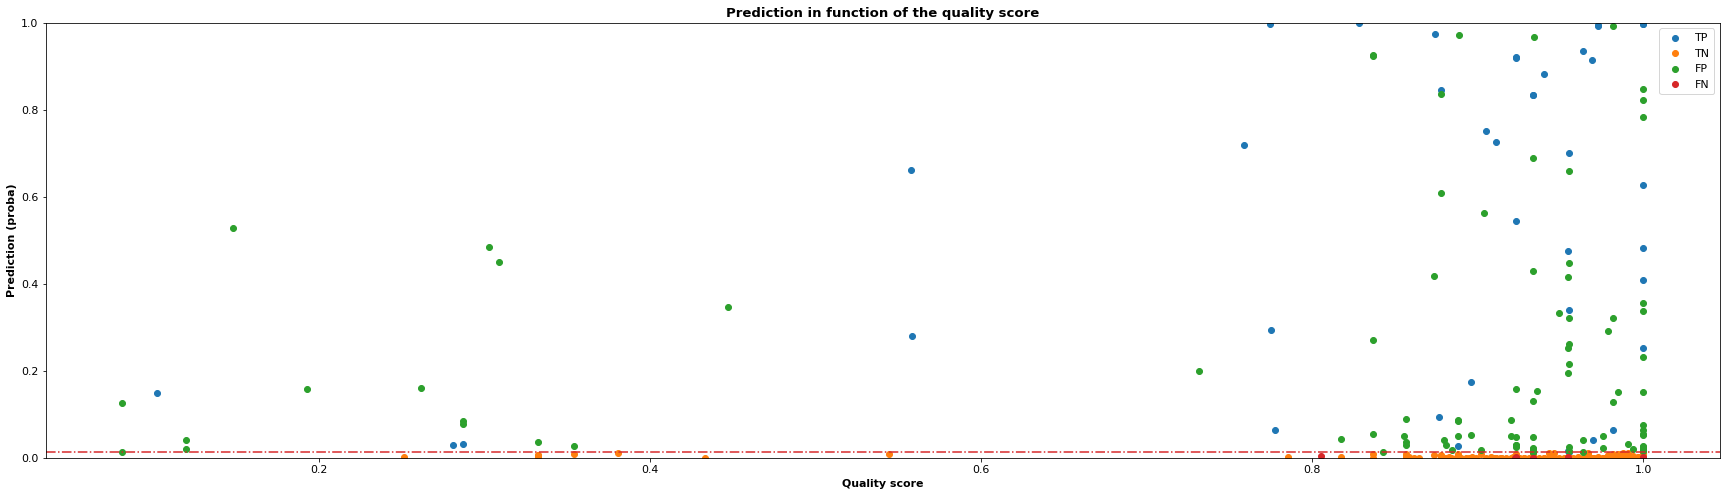

In [85]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['conf'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the quality score", weight='bold')
plt.xlabel("Quality score", weight='bold');plt.ylabel("Prediction (proba)", weight='bold')
plt.ylim([0, 1])


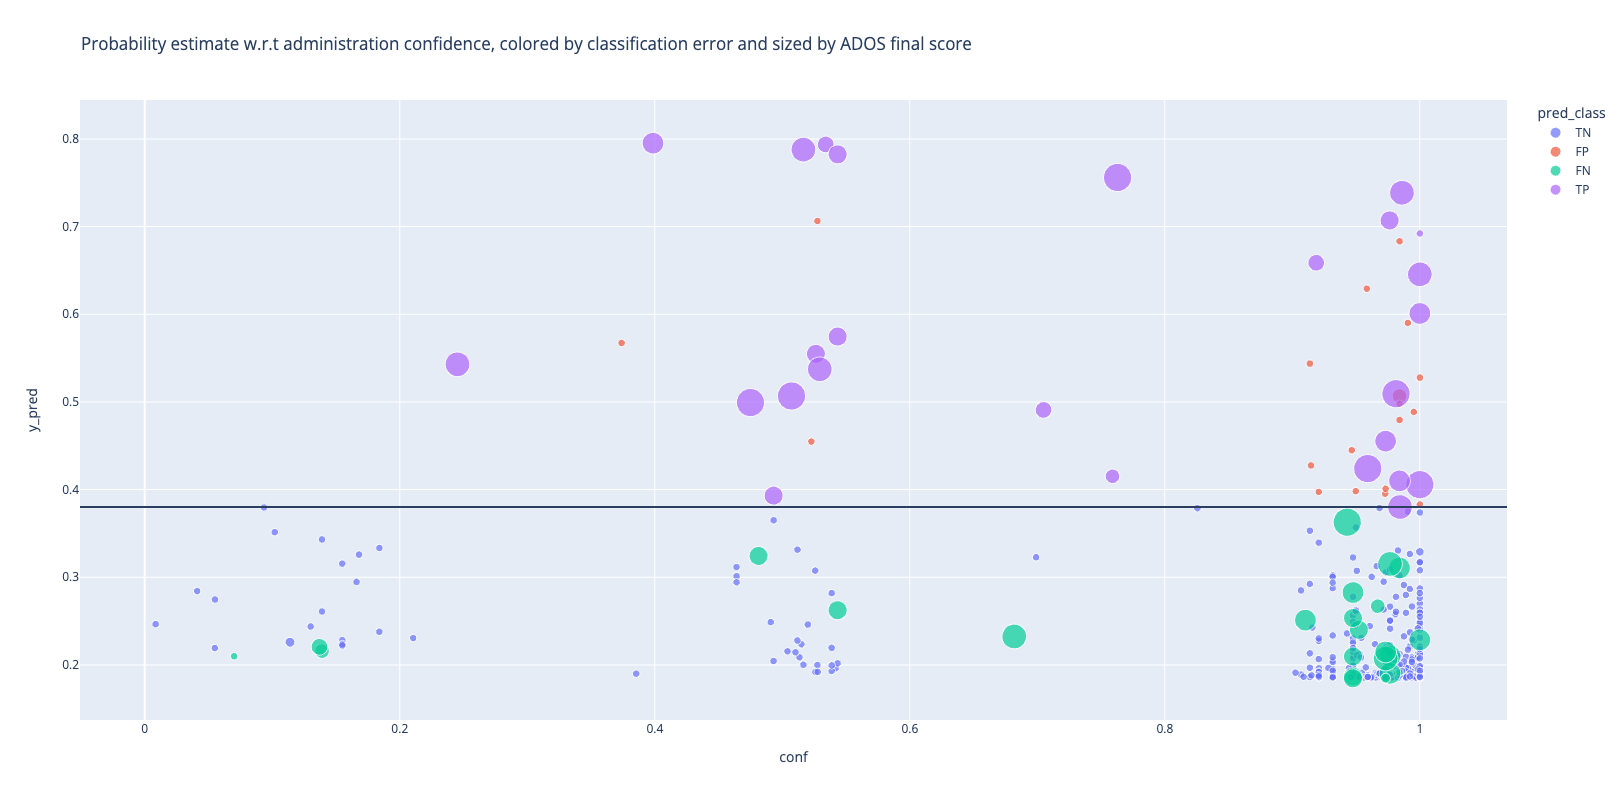

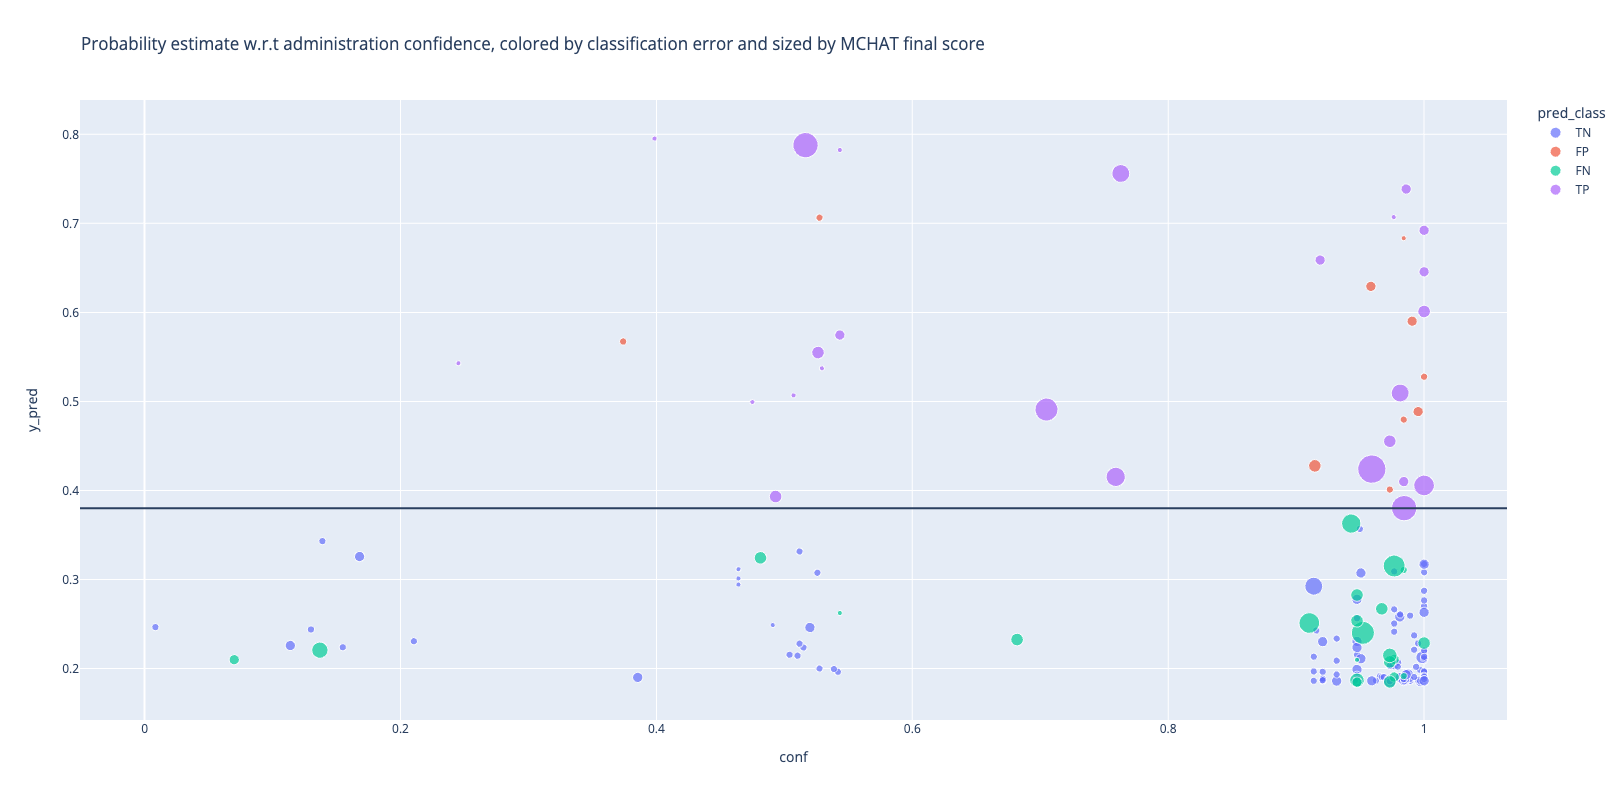

In [182]:
import plotly.express as px
df_to_plot = pd.DataFrame({'conf': exp.predictions_df['conf'].to_numpy(),
                           'y_pred': exp.predictions_df['y_pred'].to_numpy(),
                           'pred_class': exp.predictions_df['pred_class'].to_numpy(),
                           'diagnosis': exp.dataset.df['diagnosis'].to_numpy(),
                           'ados_total': exp.dataset.df['ados_total'].replace({np.nan: -1}).to_numpy(),
                           'ados_total_size': exp.dataset.df['ados_total'].apply(lambda x: 1 if np.isnan(x) else 1.3**x).to_numpy(),
                           'mchat_final': exp.dataset.df['mchat_final'].replace({np.nan: 0.5}).to_numpy(),
                           'mchat_final_size': exp.dataset.df['mchat_final'].apply(lambda x: .5 if np.isnan(x) else 1.2**x).to_numpy(),
                           # This is a proxy for whether there were strong effects among the features of that participants, or sailance
                           'norm_asbsolute_shap_values': np.abs(general_shap_values).sum(axis=1), 
                           # This is a proxy for the maximum saillant behavior
                           'max_relative_effect': (np.abs(general_shap_values) / (1e-10 + np.abs(general_shap_values).max(axis=0))).max(axis=1),
                           'id': exp.dataset.df['id'].to_numpy(),
                           'pred_class': exp.predictions_df['pred_class'].to_numpy(),
                           'size': np.ones(467)*1,
                           
                          }).round(5)

fig = px.scatter(df_to_plot, x="conf", y="y_pred", log_x=False, color='pred_class', size='ados_total_size',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'], 
                 title="Probability estimate w.r.t administration confidence, colored by classification error and sized by ADOS final score", width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()

fig = px.scatter(df_to_plot, x="conf", y="y_pred", log_x=False, color='pred_class', size='mchat_final',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'], 
                 title="Probability estimate w.r.t administration confidence, colored by classification error and sized by MCHAT final score", width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()


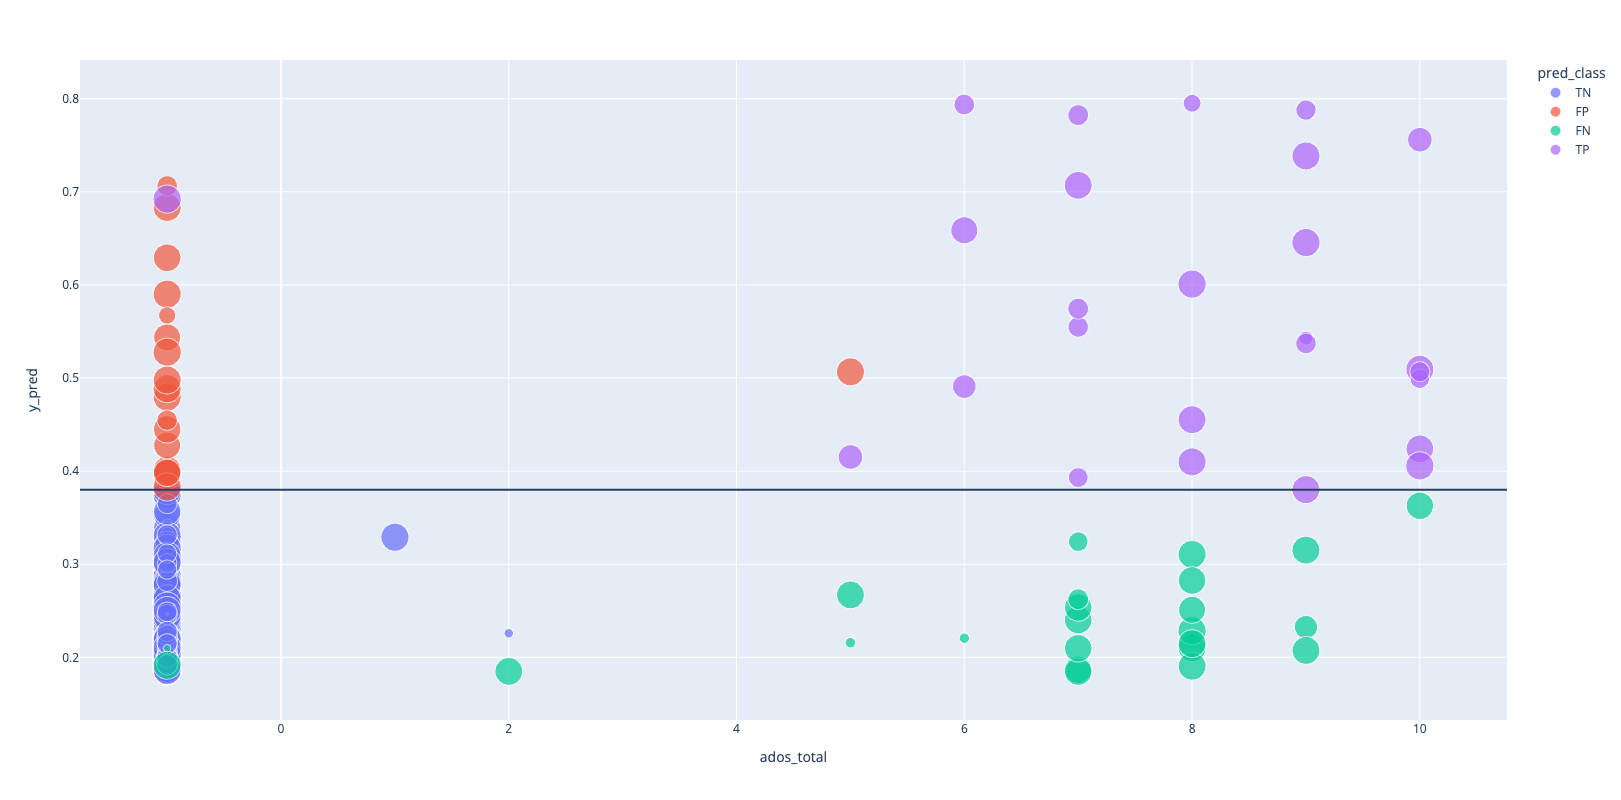

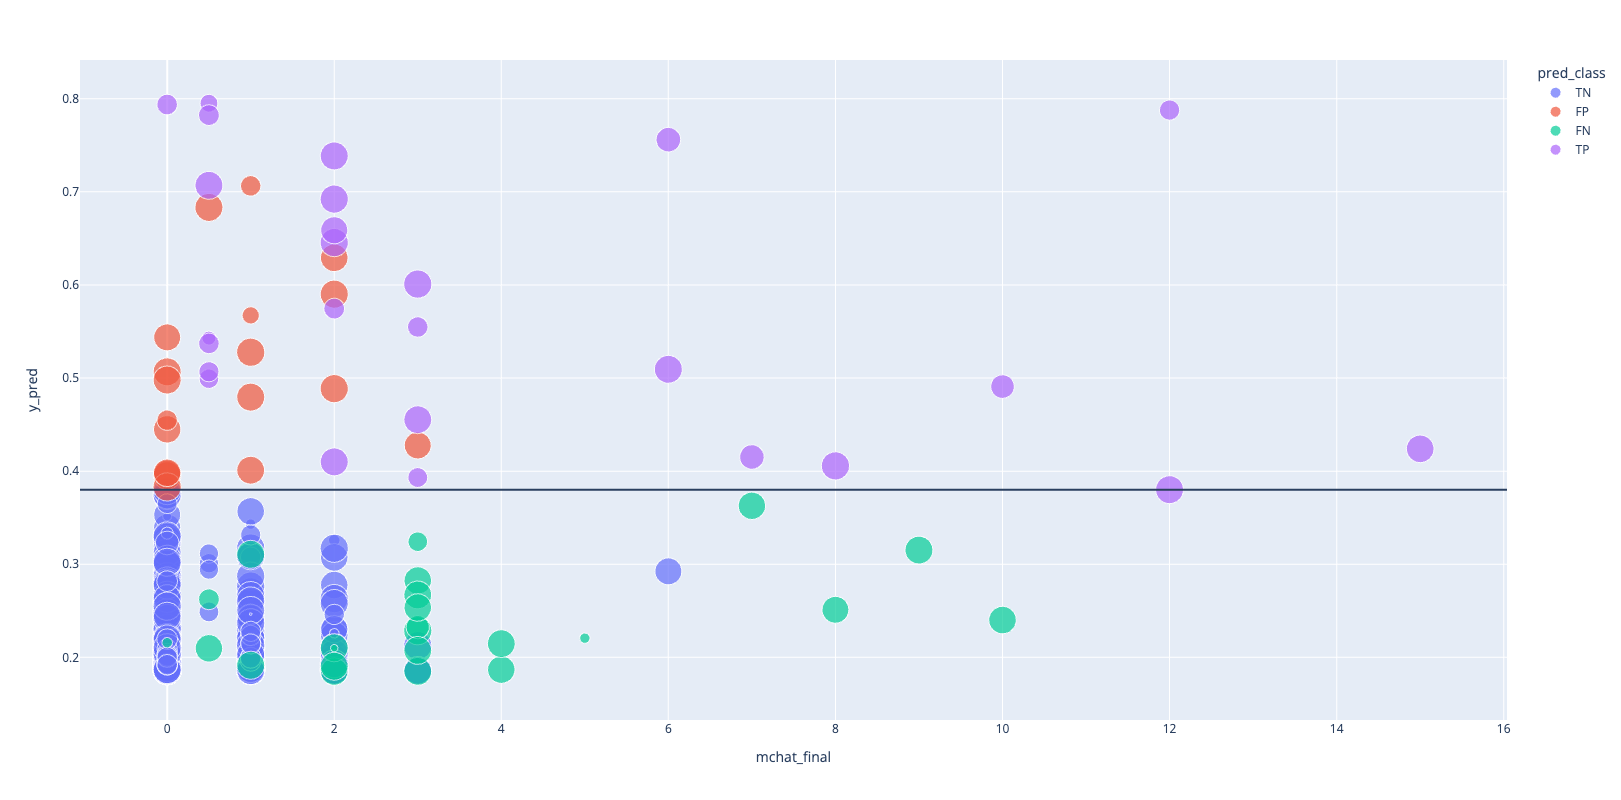

In [183]:
fig = px.scatter(df_to_plot, x="ados_total", y="y_pred", log_x=False, color='pred_class', size='conf',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'],
                 width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()

fig = px.scatter(df_to_plot, x="mchat_final", y="y_pred", log_x=False, color='pred_class', size='conf',
                 hover_name="id", hover_data=["y_pred", "conf", "ados_total", "mchat_final", 'max_relative_effect', 'norm_asbsolute_shap_values'], 
                 width=1500, height = 800)
fig.add_hline(y=exp.optimal_threshold)
fig.show()


# Measure of uncertainty from non-saillant behaviors 

In [184]:
exp.predictions_df['norm_asbsolute_shap_values'] =  (np.abs(general_shap_values)**2).sum(axis=1)
# This is a proxy for the maximum saillant behavior
exp.predictions_df['max_shap_value'] =  np.abs(general_shap_values)[:, :12].max(axis=1)# (np.abs(general_shap_values) / (1e-10 + np.abs(general_shap_values).max(axis=0))).max(axis=1)

Text(0, 0.5, 'Prediction (Proba)')

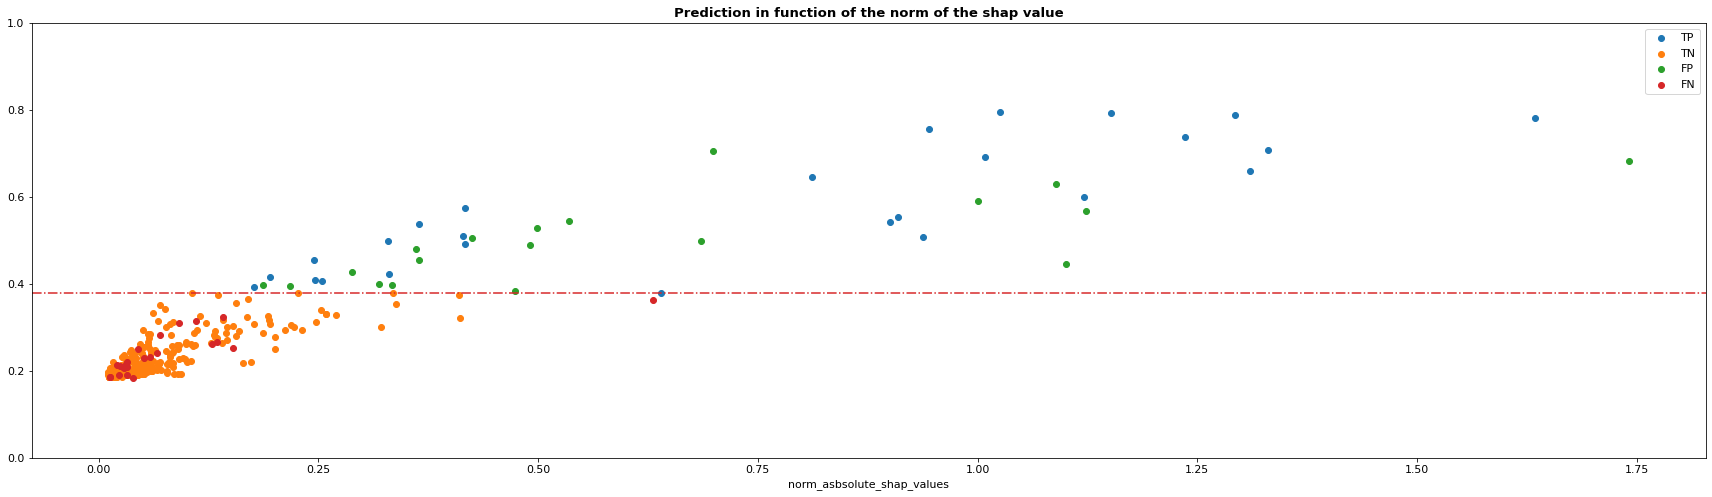

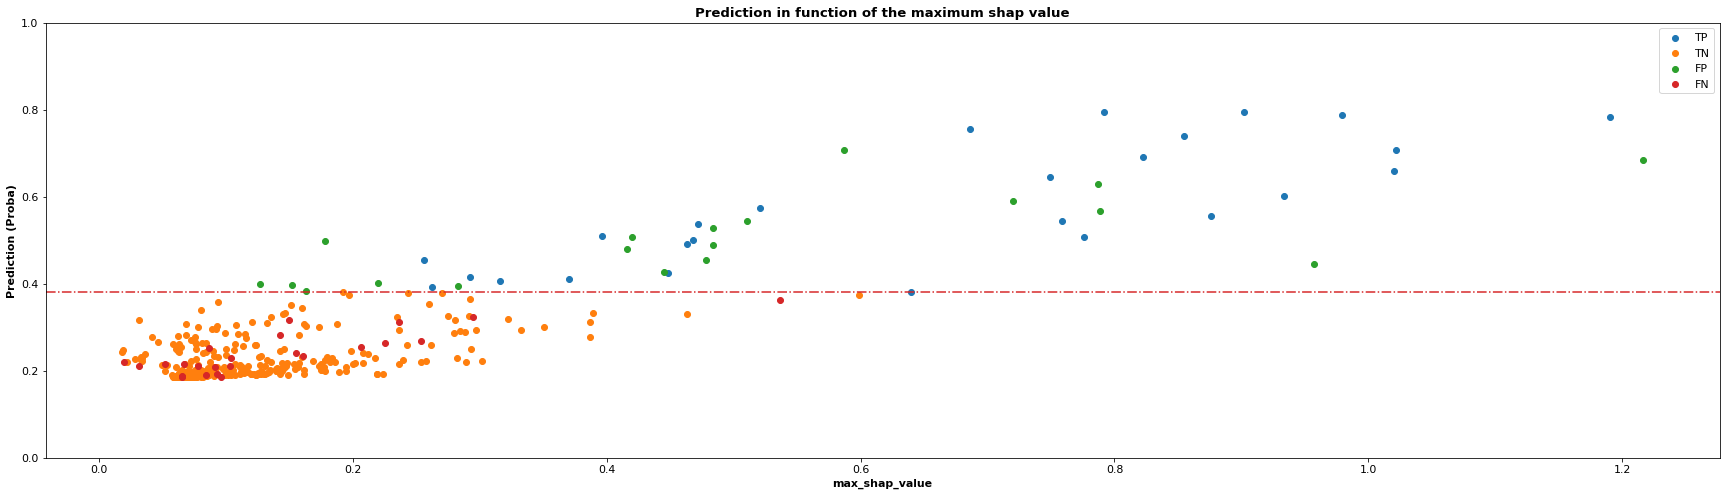

In [185]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['norm_asbsolute_shap_values'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the norm of the shap value", weight='bold')
plt.ylim([0, 1]);plt.xlabel('norm_asbsolute_shap_values')

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['max_shap_value'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the maximum shap value", weight='bold')
plt.ylim([0, 1]);plt.xlabel('max_shap_value', weight='bold'); plt.ylabel('Prediction (Proba)', weight='bold')

In [ ]:
# Ajouter a la taille des points la severite  autistique 

# Parler de la zone du milieu 


# Non linearite sur le mapping de W: mieux d'avoir 1 que 0 ou 5 que 4 ? 


# THEO proche de la moyenne a cause de comportement potentiellementx extremes mais sur des features mal notees (peu de conf)
# SOlution: utiliser la confiance en les features au moment de la prediction. Calculer des probas corriger OU PAS! Pck l'importance de cette feature elle est clair et fixe, et meme si on a 25 de confiance begh tant pis
# Classer les individus pas la somme des valeurs absolus des shap 

# Proba myene peut etre deux features aux deux extremes 
# ID: predre la norme des hsap values ... ? 






In [108]:
# We need for the feature that are missing but still have an importance (due to xgboost handling MD) to account for those by leveraging the Z !

(array([ 79., 103.,  19.,  21.,  24.,  29.,  24.,  16.,  14.,  17.,  18.,
         11.,   8.,   6.,  10.,   1.,   4.,   5.,   5.,   6.,   3.,   6.,
          2.,   1.,   1.,   2.,   2.,   3.,   1.,   3.,   1.,   2.,   2.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   3.,   1.,   1.,   4.,
          1.,   1.,   0.,   1.,   3.,   1.]),
 array([0.32612959, 0.3721671 , 0.4182046 , 0.46424211, 0.51027961,
        0.55631712, 0.60235462, 0.64839213, 0.69442963, 0.74046713,
        0.78650464, 0.83254214, 0.87857965, 0.92461715, 0.97065466,
        1.01669216, 1.06272967, 1.10876717, 1.15480468, 1.20084218,
        1.24687969, 1.29291719, 1.3389547 , 1.3849922 , 1.43102971,
        1.47706721, 1.52310472, 1.56914222, 1.61517973, 1.66121723,
        1.70725474, 1.75329224, 1.79932974, 1.84536725, 1.89140475,
        1.93744226, 1.98347976, 2.02951727, 2.07555477, 2.12159228,
        2.16762978, 2.21366729, 2.25970479, 2.3057423 , 2.3517798 ,
        2.39781731, 2.44385481, 2.48989232, 2.

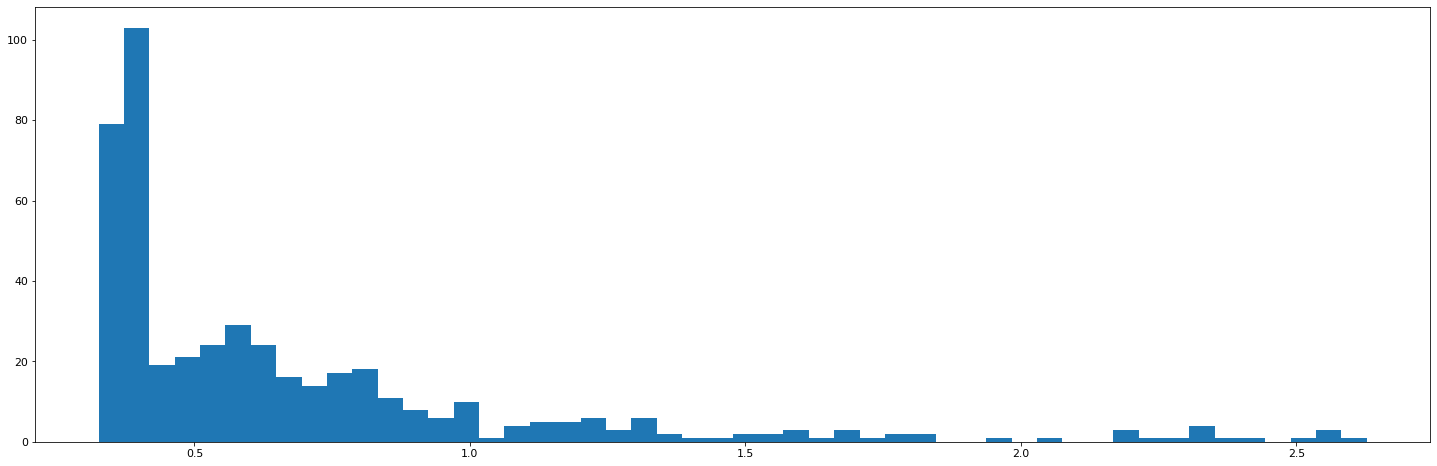

In [186]:
fi(25, 8)
plt.hist(np.abs(general_shap_values).sum(axis=1), bins=50)

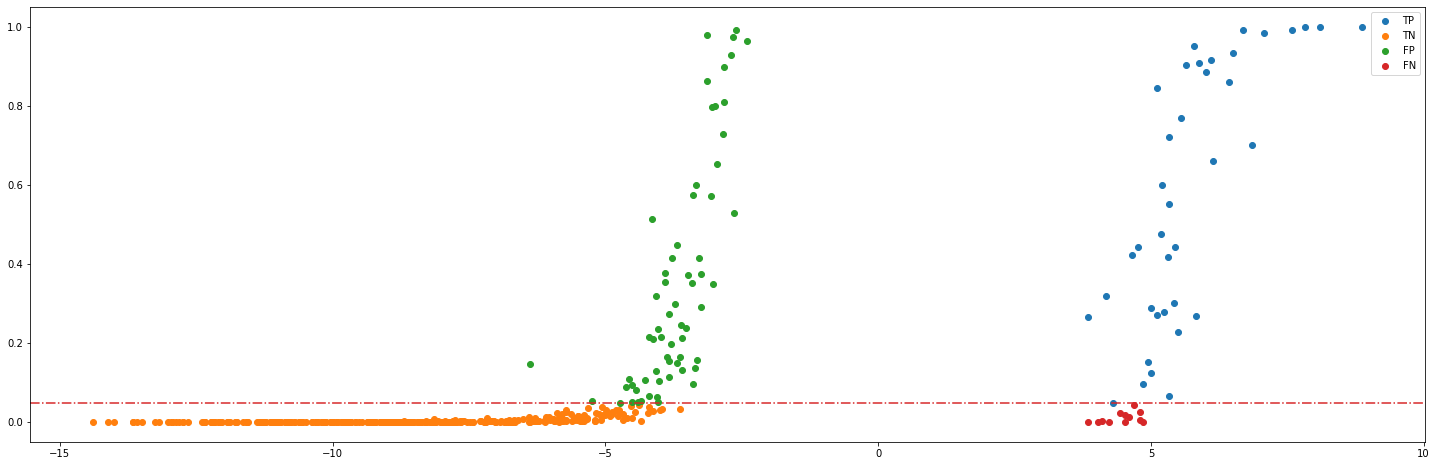

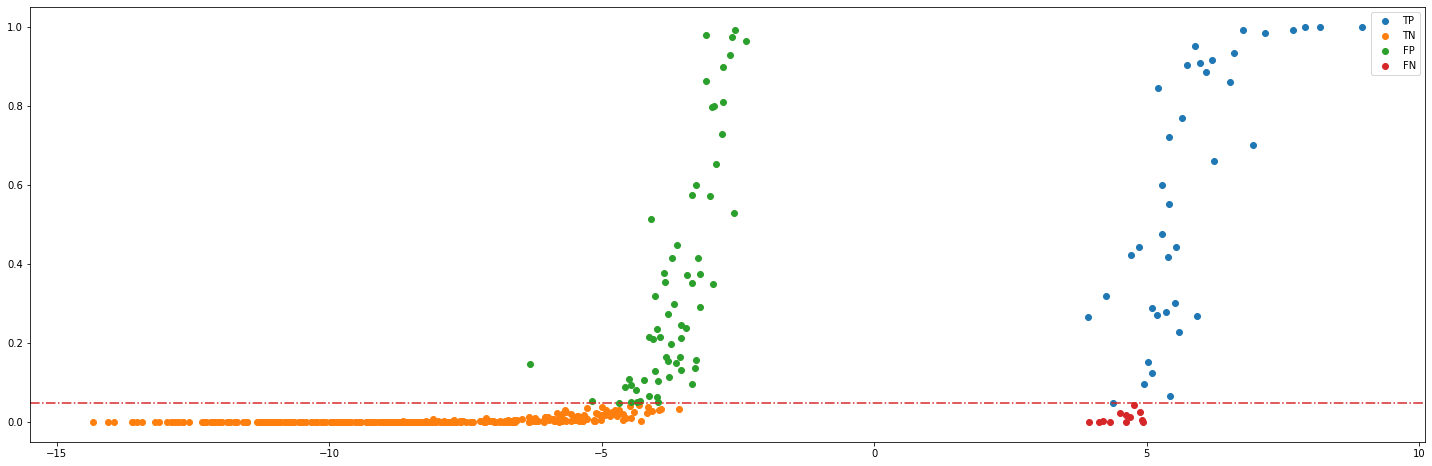

In [24]:
import shap

explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)
models_expected_value = explainer.expected_value

exp.predictions_df['f_x'] = np.nan
exp.predictions_df['f_x_all'] = np.nan


for idx in range(exp.dataset.num_samples):
    exp.predictions_df.loc[idx, 'f_x'] = shap_values[idx].sum() +  exp.models_expected_value[idx]
    exp.predictions_df.loc[idx, 'f_x_all'] = explainer.shap_values(exp.dataset.X_train)[idx].sum() +  explainer.expected_value
    
exp.predictions_df['y_pred_all'] = 1/(1 + np.exp(-exp.predictions_df['f_x'].to_numpy()))
    
exp.predictions_df.sort_values(by='f_x')[['y_pred', 'y_true','f_x', 'TP', 'TN', 'FP', 'FN']]#[:30]

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x_all'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

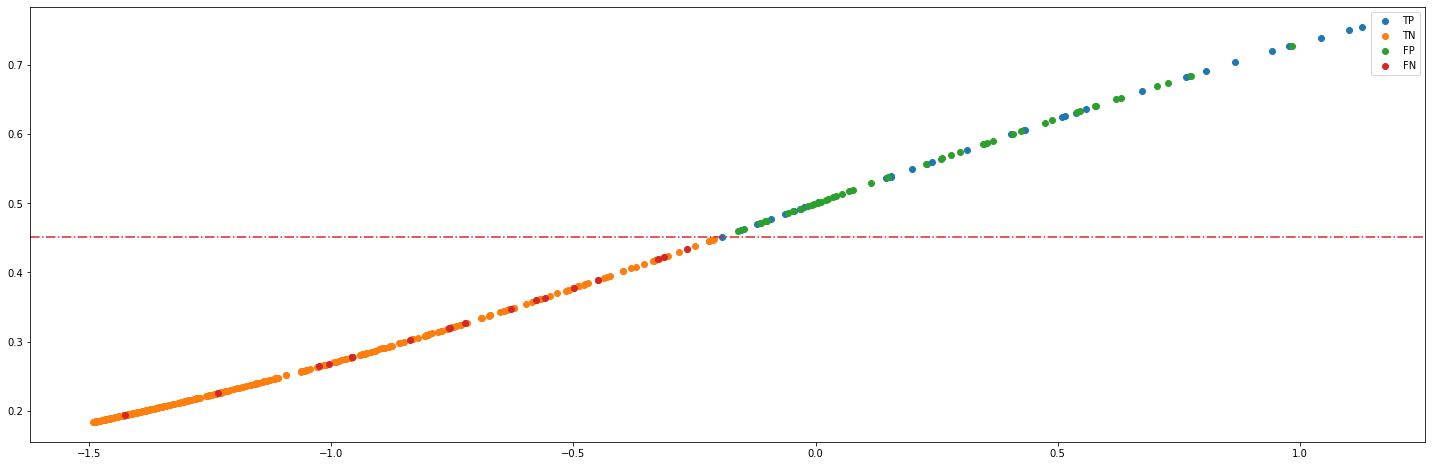

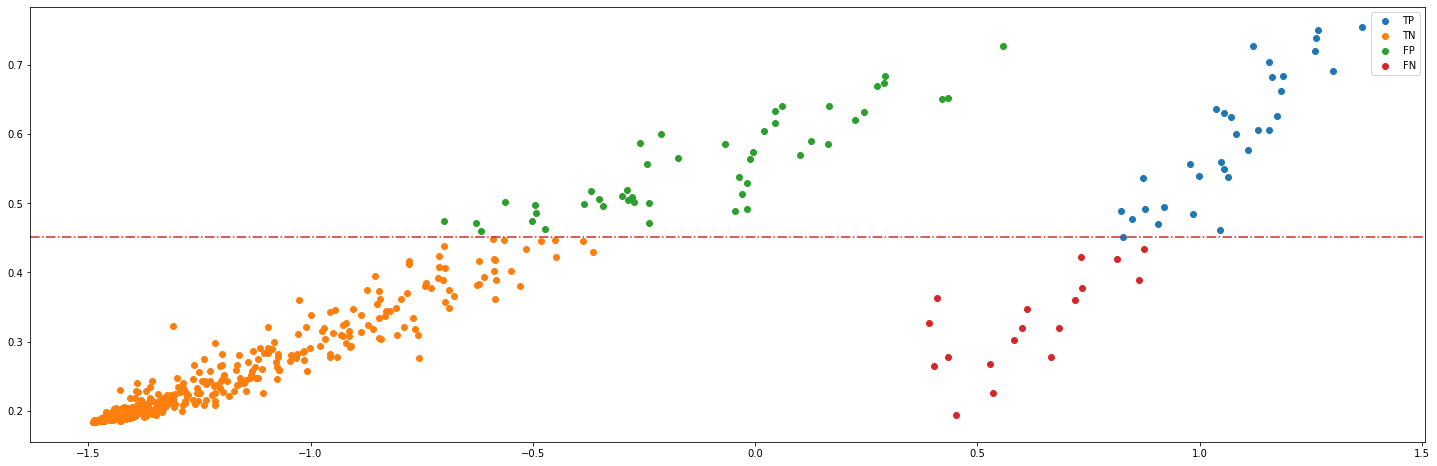

In [47]:
import shap

explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)
models_expected_value = explainer.expected_value

exp.predictions_df['f_x'] = np.nan
exp.predictions_df['f_x_all'] = np.nan


for idx in range(exp.dataset.num_samples):
    exp.predictions_df.loc[idx, 'f_x'] = shap_values[idx].sum() +  exp.models_expected_value[idx]
    exp.predictions_df.loc[idx, 'f_x_all'] = explainer.shap_values(exp.dataset.X_train)[idx].sum() +  explainer.expected_value
    
exp.predictions_df['y_pred_all'] = 1/(1 + np.exp(-exp.predictions_df['f_x'].to_numpy()))
    
exp.predictions_df.sort_values(by='f_x')[['y_pred', 'y_true','f_x', 'TP', 'TN', 'FP', 'FN']]#[:30]

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x_all'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

In [63]:
exp.predictions_df['y_pred_all'] = 1/(1 + np.exp(-exp.predictions_df['f_x_all'].to_numpy()))

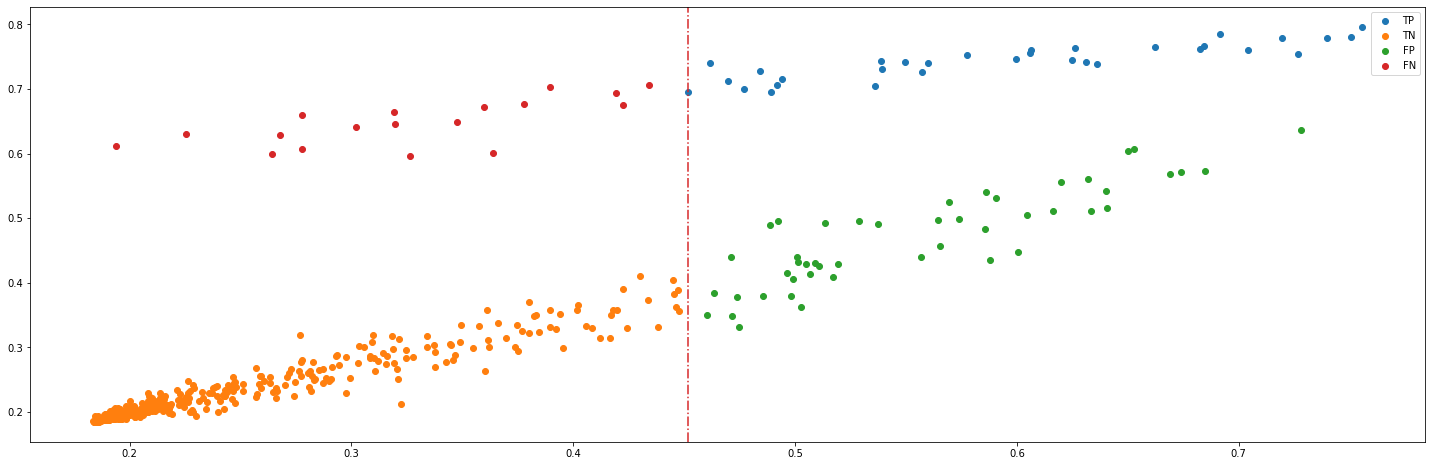

In [65]:
fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred_all'].to_numpy(), label=name)
plt.axvline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()